<a href="https://colab.research.google.com/github/Ruben474/HybridBLTPINNs/blob/main/solucionburgersredesneuronales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

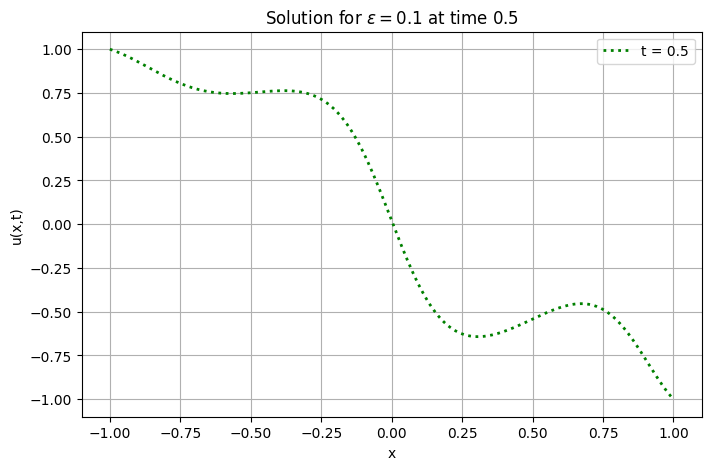

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
epsilon = 0.1  # Viscosity parameter
L = 2          # Length of the domain [-1, 1]
N = 200        # Number of points in space
dt = 0.0001    # Time step
T = 3          # Maximum time
x = np.linspace(-1, 1, N)  # Space grid

# Initial condition u(x,0) = -tanh(x/0.1)
u = -np.tanh(x / (2*0.1))

# Initialize the solution array
solutions = [u.copy()]

# Function to compute the numerical solution using finite differences
def solve_burgers(u, dt, epsilon, T):
    dx = x[1] - x[0]
    Nt = int(T / dt)

    for n in range(Nt):
        t = n * dt  # Define time at current step
        u_new = u.copy()
        for i in range(1, N-1):
            du_x = (u[i+1] - u[i-1]) / (2 * dx)
            du_xx = (u[i+1] - 2 * u[i] + u[i-1]) / dx**2
            u_new[i] = u[i] + dt * (-u[i] * du_x + epsilon * du_xx)

        # Apply boundary conditions
        u_new[0] = np.sin(np.pi * t)
        u_new[-1] = np.cos(2 * np.pi * t)
        u = u_new

        # Store solutions at t = 0, 0.25, and 0.5
        if np.isclose(t, 0.25) or np.isclose(t, 0.5):
            solutions.append(u.copy())

    return u

# Solve the Burgers' equation
solve_burgers(u, dt, epsilon, T)

# Crear un DataFrame con los valores de x y las soluciones en t = 0.5
data_finite_differences = pd.DataFrame({
    'x': x,           # Columna para los valores de x
    'u(x,t=0.5)': solutions[2]  # Columna para los valores de u(x,t=0.5)
})

# Guardar los datos en un archivo CSV con 400 puntos
file_path_finite_differences = 'finite_differences_solution_t_0.5.csv'
data_finite_differences.to_csv(file_path_finite_differences, index=False)

# Visualizar todos los resultados en t = 0.5 con los 200 datos de la malla espacial
plt.figure(figsize=(8, 5))
plt.plot(x, solutions[2], 'g:', label='t = 0.5', linewidth=2)
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Solution for $\\epsilon = 0.1$ at time 0.5')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros del problema
L = 2  # Longitud del dominio (de -1 a 1)
N = 200  # Número de puntos espaciales
dx = L / (N - 1)
x = np.linspace(-1, 1, N)
nu = 0.01  # Viscosidad
dt = 0.001  # Paso de tiempo
T = 0.5  # Tiempo total
nt = int(T / dt)  # Número de pasos de tiempo

# Condición inicial: -tanh(x/(2*nu))
u = -np.tanh(x / (2 * nu))

# Solución analítica para comparar el error
u_analitica = -np.tanh(x / (2 * nu))

# Función para diferencias hacia adelante en t y centradas en x
def diferencias_finitas(u, nt, dt, dx, nu):
    for _ in range(nt):
        u_old = u.copy()
        for i in range(1, N-1):
            u[i] = u_old[i] - u_old[i] * dt / (2 * dx) * (u_old[i+1] - u_old[i-1]) + nu * dt / dx**2 * (u_old[i+1] - 2*u_old[i] + u_old[i-1])
        # Condiciones de frontera
        u[0] = 1
        u[-1] = -1
    return u

# Ejecutar la simulación
u_numerico = diferencias_finitas(u, nt, dt, dx, nu)

# Calcular el error absoluto
error = np.abs(u_numerico - u_analitica)

# Calcular la norma L^2 del error
L2_norm_error = np.sqrt(np.sum(error**2) * dx)
L2_norm_error


0.008611637523541573

Compiling model...
Building feed-forward neural network...
'build' took 0.148454 s

'compile' took 2.006064 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.17e-02, 1.23e-01, 5.81e-01, 4.97e-01]    [1.17e-02, 1.23e-01, 5.81e-01, 4.97e-01]    []  
1000      [1.99e-02, 4.90e-02, 2.55e-02, 3.56e-02]    [1.99e-02, 4.90e-02, 2.55e-02, 3.56e-02]    []  
2000      [8.61e-03, 9.06e-03, 5.11e-03, 1.68e-02]    [8.61e-03, 9.06e-03, 5.11e-03, 1.68e-02]    []  
3000      [1.11e-02, 3.44e-03, 3.32e-03, 1.11e-02]    [1.11e-02, 3.44e-03, 3.32e-03, 1.11e-02]    []  
4000      [7.78e-03, 1.90e-03, 2.58e-03, 7.50e-03]    [7.78e-03, 1.90e-03, 2.58e-03, 7.50e-03]    []  
5000      [2.34e-03, 1.30e-03, 2.28e-03, 4.57e-03]    [2.34e-03, 1.30e-03, 2.28e-03, 4.57e-03]    []  

Best model at step 5000:
  train loss: 1.05e-02
  test loss: 1.05e-02
  test metric: []

'train' took 40.790101 s

Norma L^2 del error: 0.391

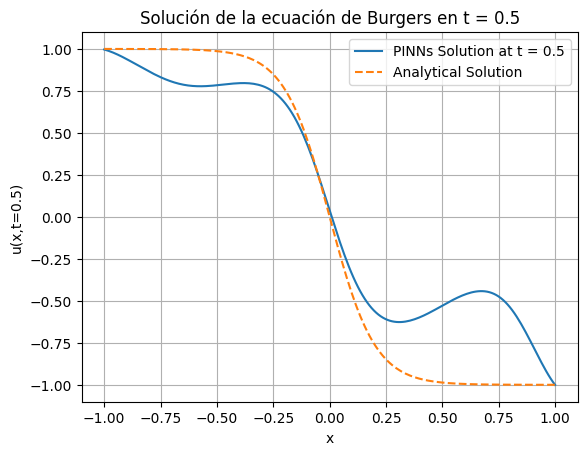

In [ ]:
import deepxde as dde
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parámetro de viscosidad
epsilon = 0.1  # Viscosity

# Definir la ecuación de Burgers con viscosidad
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Definir los límites espaciales y temporales
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Definir las condiciones de frontera ajustadas
bc_left = dde.DirichletBC(geomtime, lambda x: np.sin(np.pi * x[:, 1:2]), on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: np.cos(2 * np.pi * x[:, 1:2]), on_boundary=lambda x, _: np.isclose(x[0], 1))

# Condición inicial ajustada u(x,0)
ic = dde.IC(geomtime, lambda x: -np.tanh(x[:, 0:1] / (2 * 0.1)), lambda _, on_initial: on_initial)

# Definir el problema
data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=400, num_boundary=40, num_initial=40)

# Definir la red neuronal
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

# El modelo
model = dde.Model(data, net)

# Entrenar el modelo
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=5000)

# Generar puntos para predecir en t = 0.5
X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), 0.5 * np.ones((200, 1))))
y_pred_t = model.predict(X_t)

# Solución analítica para comparar el error
u_analitica = -np.tanh(X_t[:, 0:1] / (2 * 0.1))

# Calcular el error absoluto
error = np.abs(y_pred_t - u_analitica)

# Calcular la norma L^2 del error
L2_norm_error = np.sqrt(np.sum(error**2) * (2 / 199))

# Crear un DataFrame con los valores de x, las predicciones y la solución analítica
data_burgers = pd.DataFrame({
    'x': X_t[:, 0],
    'PINNs Prediction': y_pred_t.flatten(),
    'Analytical Solution': u_analitica.flatten(),
    'Absolute Error': error.flatten()
})

# Guardar el archivo en la ubicación correcta del entorno actual
file_path_burgers = 'burgers_pinns_solution.csv'
data_burgers.to_csv(file_path_burgers, index=False)

file_path_burgers

# Imprimir el valor del error L^2
print(f"Norma L^2 del error: {L2_norm_error}")

# Graficar las soluciones
plt.figure()
plt.plot(X_t[:, 0], y_pred_t, label="PINNs Solution at t = 0.5")
plt.plot(X_t[:, 0], u_analitica, label="Analytical Solution", linestyle="dashed")
plt.xlabel("x")
plt.ylabel("u(x,t=0.5)")
plt.legend()
plt.title("Solución de la ecuación de Burgers en t = 0.5")
plt.grid(True)
plt.show()




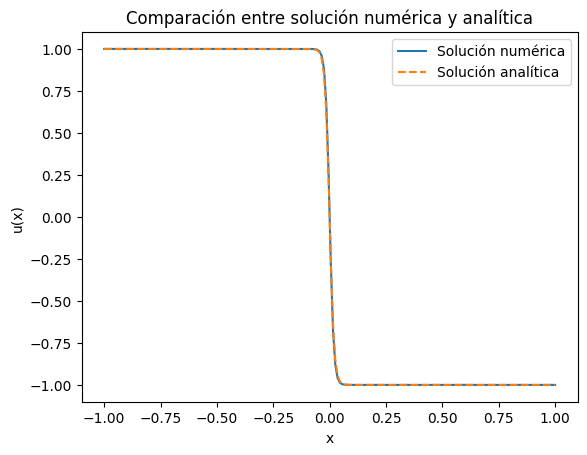

Norma L^2 del error: 0.008611637523541573


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros del problema
L = 2  # Longitud del dominio (de -1 a 1)
N = 200  # Número de puntos espaciales
dx = L / (N - 1)
x = np.linspace(-1, 1, N)
nu = 0.01  # Viscosidad
dt = 0.001  # Paso de tiempo
T = 0.5  # Tiempo total
nt = int(T / dt)  # Número de pasos de tiempo

# Condición inicial: -tanh(x/(2*nu))
u = -np.tanh(x / (2 * nu))

# Solución analítica para comparar el error
u_analitica = -np.tanh(x / (2 * nu))

# Función para diferencias hacia adelante en t y centradas en x
def diferencias_finitas(u, nt, dt, dx, nu):
    for _ in range(nt):
        u_old = u.copy()
        for i in range(1, N-1):
            u[i] = u_old[i] - u_old[i] * dt / (2 * dx) * (u_old[i+1] - u_old[i-1]) + nu * dt / dx**2 * (u_old[i+1] - 2*u_old[i] + u_old[i-1])
        # Condiciones de frontera
        u[0] = 1
        u[-1] = -1
    return u

# Ejecutar la simulación
u_numerico = diferencias_finitas(u, nt, dt, dx, nu)

# Calcular el error absoluto
error = np.abs(u_numerico - u_analitica)

# Graficar las soluciones
plt.plot(x, u_numerico, label='Solución numérica')
plt.plot(x, u_analitica, label='Solución analítica', linestyle='dashed')
plt.title('Comparación entre solución numérica y analítica')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.show()

# Calcular la norma L^2 del error
L2_norm_error = np.sqrt(np.sum(error**2) * dx)
print(f'Norma L^2 del error: {L2_norm_error}')


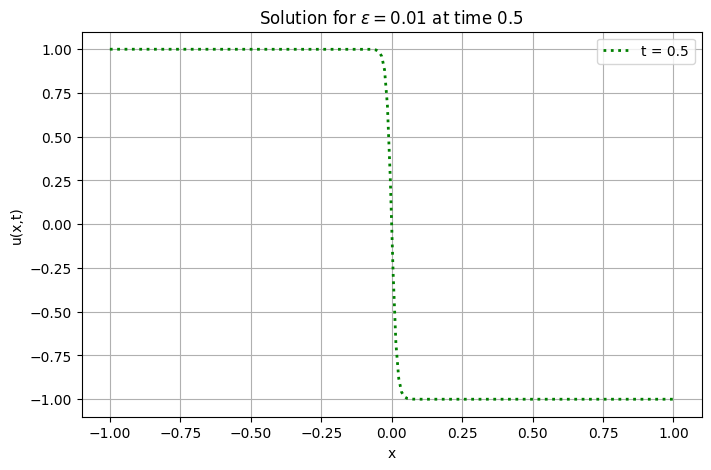

In [ ]:
# Actualizamos el código para generar 200 puntos de datos y graficar

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
epsilon = 0.01  # Viscosity parameter
L = 2          # Length of the domain [-1, 1]
N = 200        # Number of points in space
dt = 0.0001     # Time step
T = 3          # Maximum time
x = np.linspace(-1, 1, N)  # Space grid

# Initial condition u(x,0) = -tanh(x/0.1)
u = -np.tanh(x / (2*0.01))

# Initialize the solution array
solutions = [u.copy()]

# Function to compute the numerical solution using finite differences
def solve_burgers(u, dt, epsilon, T):
    dx = x[1] - x[0]
    Nt = int(T / dt)

    for n in range(Nt):
        u_new = u.copy()
        for i in range(1, N-1):
            du_x = (u[i+1] - u[i-1]) / (2 * dx)
            du_xx = (u[i+1] - 2 * u[i] + u[i-1]) / dx**2
            u_new[i] = u[i] + dt * (-u[i] * du_x + epsilon * du_xx)

        # Apply boundary conditions
        u_new[0] = np.tanh(1 / (2*0.01))
        u_new[-1] = -np.tanh(1 / (2*0.01))
        u = u_new

        # Store solutions at t = 0, 0.25, and 0.5
        if n * dt in [0, 0.25, 0.5]:
            solutions.append(u.copy())

    return u

# Solve the Burgers' equation
solve_burgers(u, dt, epsilon, T)

# Crear un DataFrame con los valores de x y las soluciones en t = 0.5
data_finite_differences = pd.DataFrame({
    'x': x,           # Columna para los valores de x
    'u(x,t=0.5)': solutions[2]  # Columna para los valores de u(x,t=0.5)
})

# Guardar los datos en un archivo CSV con 400 puntos
file_path_finite_differences = 'finite_differences_solution_t_0.5.csv'
data_finite_differences.to_csv(file_path_finite_differences, index=False)

# Visualizar todos los resultados en t = 0.5 con los 400 datos de la malla espacial
plt.figure(figsize=(8, 5))
plt.plot(x, solutions[2], 'g:', label='t = 0.5', linewidth=2)
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Solution for $\\epsilon = 0.01$ at time 0.5')
plt.legend()
plt.grid(True)
plt.show()



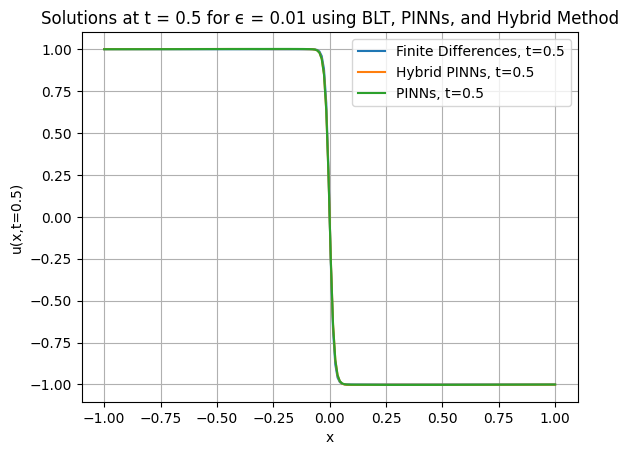

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los archivos CSV
finite_differences_data = pd.read_csv('finite_differences_solution_t_0.5.csv')
hybrid_pinns_data = pd.read_csv('hybrid_pinns_solution_t_0.5.csv')
pinns_data = pd.read_csv('pinns_solution_t_0.5.csv')

# Graficar las soluciones de los diferentes métodos en t = 0.5
plt.figure()

# Solución con diferencias finitas
plt.plot(finite_differences_data['x'], finite_differences_data['u(x,t=0.5)'], label='Finite Differences, t=0.5')

# Solución con el método híbrido BLT + PINNs
plt.plot(hybrid_pinns_data['x'], hybrid_pinns_data['u_hybridpinns(x,t=0.5)'], label='Hybrid PINNs, t=0.5')

# Solución con PINNs estándar
plt.plot(pinns_data['x'], pinns_data['u_pinns(x,t=0.5)'], label='PINNs, t=0.5')

# Detalles de la gráfica
plt.xlabel("x")
plt.ylabel("u(x,t=0.5)")
plt.title("Solutions at t = 0.5 for ϵ = 0.01 using BLT, PINNs, and Hybrid Method")
plt.legend()
plt.grid(True)

# Mostrar la gráfica
plt.show()


In [ ]:
pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.2/184.2 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 9.4 MB/s eta 0:00:00


Compiling model...
Building feed-forward neural network...
'build' took 0.131197 s

'compile' took 1.740357 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [2.47e-02, 1.58e+00, 1.84e+00, 1.31e+00]    [2.47e-02, 1.58e+00, 1.84e+00, 1.31e+00]    []  
1000      [5.65e-02, 1.95e-03, 1.79e-03, 9.44e-02]    [5.65e-02, 1.95e-03, 1.79e-03, 9.44e-02]    []  
2000      [8.71e-04, 1.26e-06, 3.41e-06, 1.22e-04]    [8.71e-04, 1.26e-06, 3.41e-06, 1.22e-04]    []  
3000      [1.15e-04, 1.17e-06, 2.57e-06, 1.62e-05]    [1.15e-04, 1.17e-06, 2.57e-06, 1.62e-05]    []  
4000      [1.24e-04, 2.77e-07, 1.78e-06, 1.11e-05]    [1.24e-04, 2.77e-07, 1.78e-06, 1.11e-05]    []  
5000      [1.98e-05, 5.27e-08, 9.07e-07, 4.48e-06]    [1.98e-05, 5.27e-08, 9.07e-07, 4.48e-06]    []  

Best model at step 5000:
  train loss: 2.53e-05
  test loss: 2.53e-05
  test metric: []

'train' took 40.387405 s



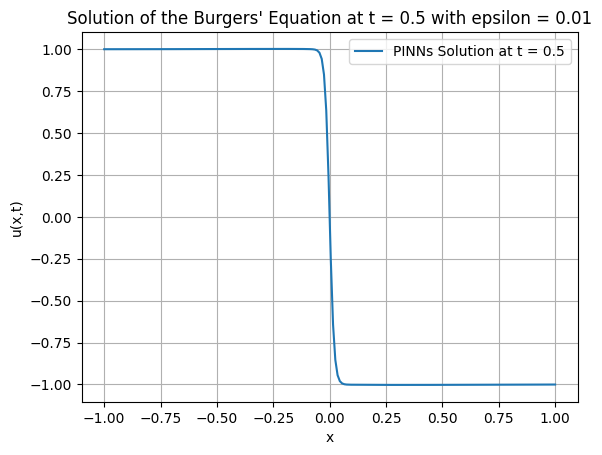

In [ ]:
import deepxde as dde
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parámetro de viscosidad
epsilon = 0.01  # Viscosity

# Definir la ecuación de Burgers con viscosidad
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Definir los límites espaciales y temporales
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Definir las condiciones de frontera ajustadas
bc_left = dde.DirichletBC(geomtime, lambda x: np.array([1]), on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: np.array([-1]), on_boundary=lambda x, _: np.isclose(x[0], 1))

# Condición inicial ajustada u(x,0)
ic = dde.IC(geomtime, lambda x: -np.tanh(x[:, 0:1] / (2*0.01)), lambda _, on_initial: on_initial)

# Definir el problema
data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=400, num_boundary=40, num_initial=40)

# Definir la red neuronal
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

# El modelo
model = dde.Model(data, net)

# Entrenar el modelo
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=5000)

# Generar puntos para predecir en t = 0.5
X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), 0.5 * np.ones((200, 1))))
y_pred_t = model.predict(X_t)

# Crear un DataFrame con los valores de x y las predicciones del modelo PINNs
data_pinns = pd.DataFrame({
    'x': X_t[:, 0],            # Columna para los valores de x
    'u_pinns(x,t=0.5)': y_pred_t.flatten()  # Columna para las predicciones de PINNs
})

# Guardar los datos en un archivo CSV
file_path_pinns = 'pinns_solution_t_0.5.csv'
data_pinns.to_csv(file_path_pinns, index=False)

# Visualización: Solución en t = 0.5
plt.figure()
plt.plot(X_t[:, 0], y_pred_t, label="PINNs Solution at t = 0.5")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.title("Solution of the Burgers' Equation at t = 0.5 with epsilon = 0.01")
plt.grid(True)
plt.show()



Compiling model...
Building feed-forward neural network...
'build' took 0.907590 s

'compile' took 2.447734 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.09e-02, 3.74e-01, 5.17e-01, 5.03e-01]    [1.09e-02, 3.74e-01, 5.17e-01, 5.03e-01]    []  
1000      [9.66e-05, 1.54e-06, 1.01e-06, 1.05e-06]    [9.66e-05, 1.54e-06, 1.01e-06, 1.05e-06]    []  
2000      [1.87e-05, 2.95e-07, 4.05e-07, 5.42e-07]    [1.87e-05, 2.95e-07, 4.05e-07, 5.42e-07]    []  
3000      [7.61e-06, 1.46e-07, 9.68e-08, 4.36e-07]    [7.61e-06, 1.46e-07, 9.68e-08, 4.36e-07]    []  
4000      [9.35e-06, 1.04e-06, 3.03e-07, 1.09e-06]    [9.35e-06, 1.04e-06, 3.03e-07, 1.09e-06]    []  
5000      [4.81e-06, 5.15e-08, 2.94e-08, 4.26e-07]    [4.81e-06, 5.15e-08, 2.94e-08, 4.26e-07]    []  

Best model at step 5000:
  train loss: 5.32e-06
  test loss: 5.32e-06
  test metric: []

'train' took 46.814965 s

Compiling model...
'compil

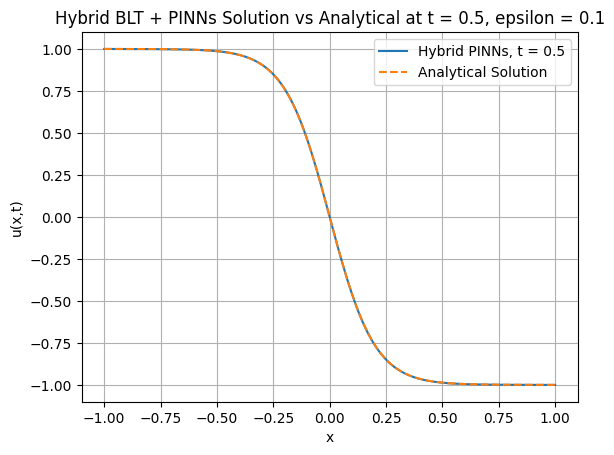

In [ ]:
import deepxde as dde
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parámetro de viscosidad
epsilon = 0.05  # Viscosity

# Aproximación para BLT (Boundary Layer Theory)
def blt_boundary_layer_solution(x, epsilon):
    return -np.tanh(x / (2 * epsilon))

# Definir la ecuación de Burgers con viscosidad
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Definir los límites espaciales y temporales
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Híbrido: Condición inicial utilizando BLT cerca de las fronteras
def hybrid_blt_ic(x):
    return np.array([blt_boundary_layer_solution(xi[0], epsilon) for xi in x]).reshape(-1, 1)

# Condiciones de frontera
bc_left = dde.DirichletBC(geomtime, lambda x: 1, on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: -1, on_boundary=lambda x, _: np.isclose(x[0], 1))

# Condición inicial con BLT
ic = dde.IC(geomtime, hybrid_blt_ic, lambda _, on_initial: on_initial)

# Definir el problema con el enfoque híbrido
data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=600, num_boundary=60, num_initial=60)

# Definir la red neuronal (mayor capacidad)
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

# Modelo híbrido (BLT + PINNs)
model = dde.Model(data, net)

# Primera fase: Entrenamiento con Adam
model.compile("adam", lr=0.0005)
losshistory, train_state = model.train(epochs=5000)

# Segunda fase: Ajuste con L-BFGS
model.compile("L-BFGS")
losshistory, train_state = model.train()

# Generar puntos para predecir en t = 0.5
X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), 0.5 * np.ones((200, 1))))
y_pred_t = model.predict(X_t)

# Solución analítica para comparar el error
u_analitica = -np.tanh(X_t[:, 0:1] / (2 * epsilon))

# Calcular el error absoluto
error = np.abs(y_pred_t - u_analitica)

# Calcular el paso espacial
dx = (1 - (-1)) / (200 - 1)

# Calcular la norma L^2 del error
L2_norm_error = np.sqrt(np.sum(error**2) * dx)

# Imprimir el valor del error L^2
print(f"Norma L^2 del error: {L2_norm_error}")

# Guardar los datos predichos por el modelo híbrido
data_hybrid_pinns = pd.DataFrame({
    'x': X_t[:, 0],            # Valores de x
    'u_hybridpinns(x,t=0.5)': y_pred_t.flatten(),  # Predicciones de Hybrid PINNs
    'u_analitica(x,t=0.5)': u_analitica.flatten()  # Solución analítica
})

# Guardar los datos en un archivo CSV
file_path_hybrid_pinns = 'hybrid_pinns_solution_t_0.5.csv'
data_hybrid_pinns.to_csv(file_path_hybrid_pinns, index=False)

print(f"Datos guardados en {file_path_hybrid_pinns}")

# Visualización: Solución en t = 0.5
plt.figure()
plt.plot(X_t[:, 0], y_pred_t, label="Hybrid PINNs, t = 0.5")
plt.plot(X_t[:, 0], u_analitica, label="Analytical Solution", linestyle="dashed")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.title("Hybrid BLT + PINNs Solution vs Analytical at t = 0.5, epsilon = 0.1")
plt.grid(True)
plt.show()


Compiling model...
Building feed-forward neural network...
'build' took 0.212904 s

'compile' took 3.947645 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.24e-02, 3.74e-01, 5.22e-01, 5.98e-01]    [1.24e-02, 3.74e-01, 5.22e-01, 5.98e-01]    []  
1000      [1.03e-04, 6.89e-06, 2.94e-06, 3.50e-06]    [1.03e-04, 6.89e-06, 2.94e-06, 3.50e-06]    []  
2000      [1.62e-05, 1.10e-06, 5.08e-07, 8.60e-07]    [1.62e-05, 1.10e-06, 5.08e-07, 8.60e-07]    []  
3000      [9.36e-06, 1.73e-07, 9.84e-08, 1.92e-07]    [9.36e-06, 1.73e-07, 9.84e-08, 1.92e-07]    []  
4000      [6.73e-06, 3.49e-08, 3.18e-08, 2.19e-07]    [6.73e-06, 3.49e-08, 3.18e-08, 2.19e-07]    []  
5000      [5.24e-06, 1.19e-08, 1.27e-08, 3.56e-07]    [5.24e-06, 1.19e-08, 1.27e-08, 3.56e-07]    []  

Best model at step 5000:
  train loss: 5.62e-06
  test loss: 5.62e-06
  test metric: []

'train' took 52.327019 s

Compiling model...
'compil

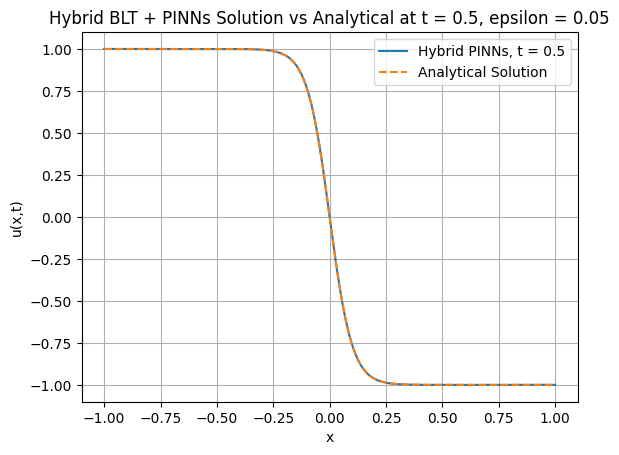

In [ ]:
import deepxde as dde
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parámetro de viscosidad
epsilon = 0.05  # Viscosity

# Aproximación para BLT (Boundary Layer Theory)
def blt_boundary_layer_solution(x, epsilon):
    return -np.tanh(x / (2 * epsilon))

# Definir la ecuación de Burgers con viscosidad
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Definir los límites espaciales y temporales
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Híbrido: Condición inicial utilizando BLT cerca de las fronteras
def hybrid_blt_ic(x):
    return np.array([blt_boundary_layer_solution(xi[0], epsilon) for xi in x]).reshape(-1, 1)

# Condiciones de frontera
bc_left = dde.DirichletBC(geomtime, lambda x: 1, on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: -1, on_boundary=lambda x, _: np.isclose(x[0], 1))

# Condición inicial con BLT
ic = dde.IC(geomtime, hybrid_blt_ic, lambda _, on_initial: on_initial)

# Definir el problema con el enfoque híbrido
data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=600, num_boundary=60, num_initial=60)

# Definir la red neuronal (mayor capacidad)
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

# Modelo híbrido (BLT + PINNs)
model = dde.Model(data, net)

# Primera fase: Entrenamiento con Adam
model.compile("adam", lr=0.0005)
losshistory, train_state = model.train(epochs=5000)

# Segunda fase: Ajuste con L-BFGS
model.compile("L-BFGS")
losshistory, train_state = model.train()

# Generar puntos para predecir en t = 0.5
X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), 0.5 * np.ones((200, 1))))
y_pred_t = model.predict(X_t)

# Solución analítica para comparar el error
u_analitica = -np.tanh(X_t[:, 0:1] / (2 * epsilon))

# Calcular el error absoluto
error = np.abs(y_pred_t - u_analitica)

# Calcular el paso espacial
dx = (1 - (-1)) / (200 - 1)

# Calcular la norma L^2 del error
L2_norm_error = np.sqrt(np.sum(error**2) * dx)

# Imprimir el valor del error L^2
print(f"Norma L^2 del error: {L2_norm_error}")

# Guardar los datos predichos por el modelo híbrido
data_hybrid_pinns = pd.DataFrame({
    'x': X_t[:, 0],            # Valores de x
    'u_hybridpinns(x,t=0.5)': y_pred_t.flatten(),  # Predicciones de Hybrid PINNs
    'u_analitica(x,t=0.5)': u_analitica.flatten()  # Solución analítica
})

# Guardar los datos en un archivo CSV
file_path_hybrid_pinns = 'hybrid_pinns_solution_epsilon_0.05_t_0.5.csv'
data_hybrid_pinns.to_csv(file_path_hybrid_pinns, index=False)

print(f"Datos guardados en {file_path_hybrid_pinns}")

# Visualización: Solución en t = 0.5
plt.figure()
plt.plot(X_t[:, 0], y_pred_t, label="Hybrid PINNs, t = 0.5")
plt.plot(X_t[:, 0], u_analitica, label="Analytical Solution", linestyle="dashed")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.title("Hybrid BLT + PINNs Solution vs Analytical at t = 0.5, epsilon = 0.05")
plt.grid(True)
plt.show()


Compiling model...
Building feed-forward neural network...
'build' took 0.375401 s

'compile' took 2.315727 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.29e-02, 3.68e-01, 5.10e-01, 6.67e-01]    [1.29e-02, 3.68e-01, 5.10e-01, 6.67e-01]    []  
1000      [6.02e-02, 1.08e-03, 1.96e-03, 9.17e-02]    [6.02e-02, 1.08e-03, 1.96e-03, 9.17e-02]    []  
2000      [1.60e-04, 9.05e-07, 1.61e-06, 7.67e-06]    [1.60e-04, 9.05e-07, 1.61e-06, 7.67e-06]    []  
3000      [4.35e-05, 6.56e-08, 2.73e-07, 1.34e-06]    [4.35e-05, 6.56e-08, 2.73e-07, 1.34e-06]    []  
4000      [1.73e-05, 6.60e-07, 3.94e-07, 1.46e-06]    [1.73e-05, 6.60e-07, 3.94e-07, 1.46e-06]    []  
5000      [2.52e-05, 7.12e-06, 6.11e-06, 6.49e-06]    [2.52e-05, 7.12e-06, 6.11e-06, 6.49e-06]    []  

Best model at step 4000:
  train loss: 1.98e-05
  test loss: 1.98e-05
  test metric: []

'train' took 55.084934 s

Compiling model...
'compil

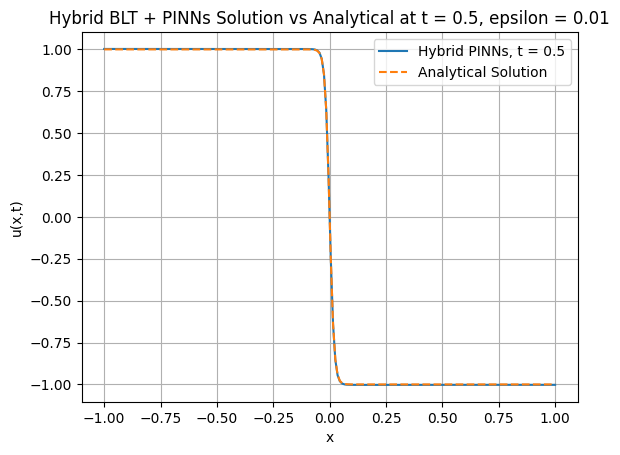

In [ ]:
import deepxde as dde
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parámetro de viscosidad
epsilon = 0.01  # Viscosity

# Aproximación para BLT (Boundary Layer Theory)
def blt_boundary_layer_solution(x, epsilon):
    return -np.tanh(x / (2 * epsilon))

# Definir la ecuación de Burgers con viscosidad
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Definir los límites espaciales y temporales
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Híbrido: Condición inicial utilizando BLT cerca de las fronteras
def hybrid_blt_ic(x):
    return np.array([blt_boundary_layer_solution(xi[0], epsilon) for xi in x]).reshape(-1, 1)

# Condiciones de frontera
bc_left = dde.DirichletBC(geomtime, lambda x: 1, on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: -1, on_boundary=lambda x, _: np.isclose(x[0], 1))

# Condición inicial con BLT
ic = dde.IC(geomtime, hybrid_blt_ic, lambda _, on_initial: on_initial)

# Definir el problema con el enfoque híbrido
data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=600, num_boundary=60, num_initial=60)

# Definir la red neuronal (mayor capacidad)
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

# Modelo híbrido (BLT + PINNs)
model = dde.Model(data, net)

# Primera fase: Entrenamiento con Adam
model.compile("adam", lr=0.0005)
losshistory, train_state = model.train(epochs=5000)

# Segunda fase: Ajuste con L-BFGS
model.compile("L-BFGS")
losshistory, train_state = model.train()

# Generar puntos para predecir en t = 0.5
X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), 0.5 * np.ones((200, 1))))
y_pred_t = model.predict(X_t)

# Solución analítica para comparar el error
u_analitica = -np.tanh(X_t[:, 0:1] / (2 * epsilon))

# Calcular el error absoluto
error = np.abs(y_pred_t - u_analitica)

# Calcular el paso espacial
dx = (1 - (-1)) / (200 - 1)

# Calcular la norma L^2 del error
L2_norm_error = np.sqrt(np.sum(error**2) * dx)

# Imprimir el valor del error L^2
print(f"Norma L^2 del error: {L2_norm_error}")

# Guardar los datos predichos por el modelo híbrido
data_hybrid_pinns = pd.DataFrame({
    'x': X_t[:, 0],            # Valores de x
    'u_hybridpinns(x,t=0.5)': y_pred_t.flatten(),  # Predicciones de Hybrid PINNs
    'u_analitica(x,t=0.5)': u_analitica.flatten()  # Solución analítica
})

# Guardar los datos en un archivo CSV
file_path_hybrid_pinns = 'hybrid_pinns_solution_epsilon_0.01_t_0.5.csv'
data_hybrid_pinns.to_csv(file_path_hybrid_pinns, index=False)

print(f"Datos guardados en {file_path_hybrid_pinns}")

# Visualización: Solución en t = 0.5
plt.figure()
plt.plot(X_t[:, 0], y_pred_t, label="Hybrid PINNs, t = 0.5")
plt.plot(X_t[:, 0], u_analitica, label="Analytical Solution", linestyle="dashed")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.title("Hybrid BLT + PINNs Solution vs Analytical at t = 0.5, epsilon = 0.01")
plt.grid(True)
plt.show()


Compiling model...
Building feed-forward neural network...
'build' took 0.073142 s

'compile' took 1.102277 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.30e-02, 3.80e-01, 5.28e-01, 1.20e-01]    [1.30e-02, 3.80e-01, 5.28e-01, 1.20e-01]    []  
1000      [2.86e-02, 1.37e-02, 2.90e-02, 7.85e-02]    [2.86e-02, 1.37e-02, 2.90e-02, 7.85e-02]    []  
2000      [5.90e-03, 2.09e-03, 9.36e-04, 9.93e-03]    [5.90e-03, 2.09e-03, 9.36e-04, 9.93e-03]    []  
3000      [2.31e-03, 8.26e-04, 3.62e-04, 4.04e-03]    [2.31e-03, 8.26e-04, 3.62e-04, 4.04e-03]    []  
4000      [1.57e-03, 5.84e-04, 2.84e-04, 2.51e-03]    [1.57e-03, 5.84e-04, 2.84e-04, 2.51e-03]    []  
5000      [1.14e-03, 4.11e-04, 2.35e-04, 1.74e-03]    [1.14e-03, 4.11e-04, 2.35e-04, 1.74e-03]    []  

Best model at step 5000:
  train loss: 3.53e-03
  test loss: 3.53e-03
  test metric: []

'train' took 63.266277 s

Compiling model...
'compil

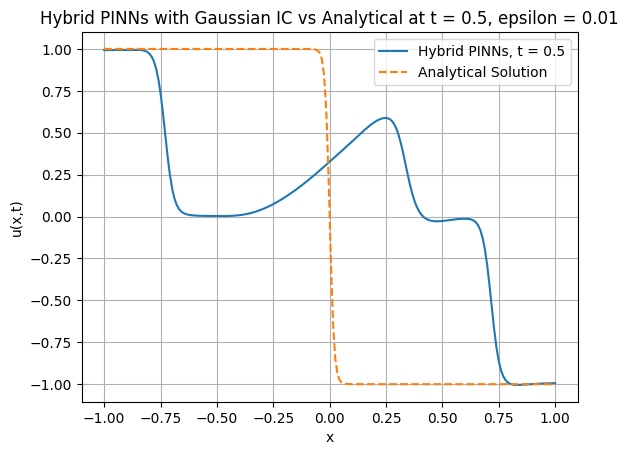

In [ ]:
import deepxde as dde
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parámetro de viscosidad
epsilon = 0.01  # Viscosity

# Definir la ecuación de Burgers con viscosidad
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Definir los límites espaciales y temporales
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Condición inicial: Perfil Gaussiano
def gaussian_ic(x):
    x0 = 0  # Centro del perfil
    sigma = 0.1  # Desviación estándar
    return np.exp(-((x[:, 0:1] - x0) ** 2) / (2 * sigma ** 2))

# Condiciones de frontera
bc_left = dde.DirichletBC(geomtime, lambda x: 1, on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: -1, on_boundary=lambda x, _: np.isclose(x[0], 1))

# Condición inicial con perfil gaussiano
ic = dde.IC(geomtime, gaussian_ic, lambda _, on_initial: on_initial)

# Definir el problema
data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=600, num_boundary=60, num_initial=60)

# Definir la red neuronal (mayor capacidad)
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

# Modelo híbrido (Gaussian IC + PINNs)
model = dde.Model(data, net)

# Primera fase: Entrenamiento con Adam
model.compile("adam", lr=0.0005)
losshistory, train_state = model.train(epochs=5000)

# Segunda fase: Ajuste con L-BFGS
model.compile("L-BFGS")
losshistory, train_state = model.train()

# Generar puntos para predecir en t = 0.5
X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), 0.5 * np.ones((200, 1))))
y_pred_t = model.predict(X_t)

# Solución analítica para comparar el error
u_analitica = -np.tanh(X_t[:, 0:1] / (2 * epsilon))

# Calcular el error absoluto
error = np.abs(y_pred_t - u_analitica)

# Calcular el paso espacial
dx = (1 - (-1)) / (200 - 1)

# Calcular la norma L^2 del error
L2_norm_error = np.sqrt(np.sum(error**2) * dx)

# Imprimir el valor del error L^2
print(f"Norma L^2 del error: {L2_norm_error}")

# Guardar los datos predichos por el modelo
data_hybrid_pinns = pd.DataFrame({
    'x': X_t[:, 0],            # Valores de x
    'u_gaussianhybridpinns(x,t=0.5)': y_pred_t.flatten(),  # Predicciones de Hybrid PINNs
    'u_analitica(x,t=0.5)': u_analitica.flatten()  # Solución analítica
})

# Guardar los datos en un archivo CSV
file_path_hybrid_pinns = 'hybrid_pinns_gaussian_solution_epsilon_0.01_t_0.5.csv'
data_hybrid_pinns.to_csv(file_path_hybrid_pinns, index=False)

print(f"Datos guardados en {file_path_hybrid_pinns}")

# Visualización: Solución en t = 0.5
plt.figure()
plt.plot(X_t[:, 0], y_pred_t, label="Hybrid PINNs, t = 0.5")
plt.plot(X_t[:, 0], u_analitica, label="Analytical Solution", linestyle="dashed")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.title("Hybrid PINNs with Gaussian IC vs Analytical at t = 0.5, epsilon = 0.01")
plt.grid(True)
plt.show()


Compiling model...
Building feed-forward neural network...
'build' took 0.135179 s

'compile' took 1.960059 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.26e-02, 3.77e-01, 5.27e-01, 6.87e-01]    [1.26e-02, 3.77e-01, 5.27e-01, 6.87e-01]    []  
1000      [6.17e-02, 1.82e-03, 1.70e-03, 1.02e-01]    [6.17e-02, 1.82e-03, 1.70e-03, 1.02e-01]    []  
2000      [1.24e-04, 1.51e-06, 7.13e-07, 2.25e-04]    [1.24e-04, 1.51e-06, 7.13e-07, 2.25e-04]    []  
3000      [3.24e-05, 5.26e-07, 4.27e-07, 2.17e-04]    [3.24e-05, 5.26e-07, 4.27e-07, 2.17e-04]    []  
4000      [2.34e-05, 2.01e-07, 1.32e-07, 2.06e-04]    [2.34e-05, 2.01e-07, 1.32e-07, 2.06e-04]    []  
5000      [5.95e-05, 2.83e-06, 8.61e-07, 2.09e-04]    [5.95e-05, 2.83e-06, 8.61e-07, 2.09e-04]    []  

Best model at step 4000:
  train loss: 2.30e-04
  test loss: 2.30e-04
  test metric: []

'train' took 73.606921 s

Compiling model...
'compil

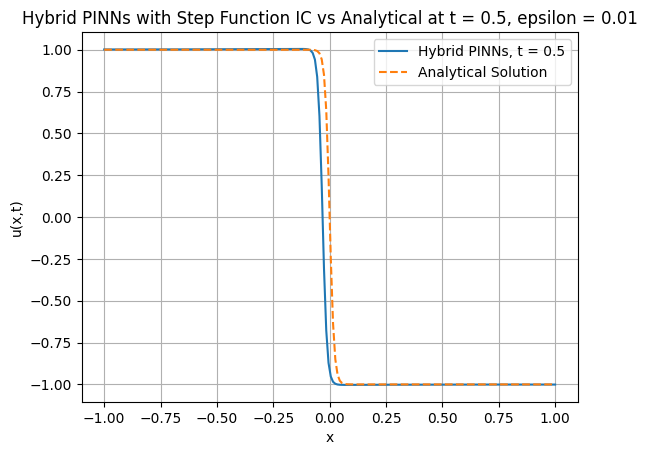

In [ ]:
import deepxde as dde
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parámetro de viscosidad
epsilon = 0.01  # Viscosity

# Definir la ecuación de Burgers con viscosidad
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Definir los límites espaciales y temporales
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Condición inicial: Función escalón
def step_ic(x):
    return np.where(x[:, 0:1] < 0, 1.0, -1.0)

# Condiciones de frontera
bc_left = dde.DirichletBC(geomtime, lambda x: 1, on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: -1, on_boundary=lambda x, _: np.isclose(x[0], 1))

# Condición inicial con función escalón
ic = dde.IC(geomtime, step_ic, lambda _, on_initial: on_initial)

# Definir el problema
data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=600, num_boundary=60, num_initial=60)

# Definir la red neuronal (mayor capacidad)
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

# Modelo híbrido (Step IC + PINNs)
model = dde.Model(data, net)

# Primera fase: Entrenamiento con Adam
model.compile("adam", lr=0.0005)
losshistory, train_state = model.train(epochs=5000)

# Segunda fase: Ajuste con L-BFGS
model.compile("L-BFGS")
losshistory, train_state = model.train()

# Generar puntos para predecir en t = 0.5
X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), 0.5 * np.ones((200, 1))))
y_pred_t = model.predict(X_t)

# Solución analítica para comparar el error
u_analitica = -np.tanh(X_t[:, 0:1] / (2 * epsilon))

# Calcular el error absoluto
error = np.abs(y_pred_t - u_analitica)

# Calcular el paso espacial
dx = (1 - (-1)) / (200 - 1)

# Calcular la norma L^2 del error
L2_norm_error = np.sqrt(np.sum(error**2) * dx)

# Imprimir el valor del error L2
print(f"Norma L^2 del error: {L2_norm_error}")

# Guardar los datos predichos por el modelo
data_hybrid_pinns = pd.DataFrame({
    'x': X_t[:, 0],            # Valores de x
    'u_stephybridpinns(x,t=0.5)': y_pred_t.flatten(),  # Predicciones de Hybrid PINNs
    'u_analitica(x,t=0.5)': u_analitica.flatten()  # Solución analítica
})

# Guardar los datos en un archivo CSV
file_path_hybrid_pinns = 'hybrid_pinns_step_solution_epsilon_0.01_t_0.5.csv'
data_hybrid_pinns.to_csv(file_path_hybrid_pinns, index=False)

print(f"Datos guardados en {file_path_hybrid_pinns}")

# Visualización: Solución en t = 0.5
plt.figure()
plt.plot(X_t[:, 0], y_pred_t, label="Hybrid PINNs, t = 0.5")
plt.plot(X_t[:, 0], u_analitica, label="Analytical Solution", linestyle="dashed")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.title("Hybrid PINNs with Step Function IC vs Analytical at t = 0.5, epsilon = 0.01")
plt.grid(True)
plt.show()


Compiling model...
Building feed-forward neural network...
'build' took 0.133746 s

'compile' took 2.462339 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.26e-02, 3.78e-01, 5.29e-01, 7.96e-01]    [1.26e-02, 3.78e-01, 5.29e-01, 7.96e-01]    []  
1000      [9.66e-02, 1.90e-02, 7.35e-03, 1.35e-01]    [9.66e-02, 1.90e-02, 7.35e-03, 1.35e-01]    []  
2000      [1.46e-02, 5.59e-04, 6.21e-04, 1.74e-02]    [1.46e-02, 5.59e-04, 6.21e-04, 1.74e-02]    []  
3000      [6.37e-03, 3.44e-04, 1.53e-04, 1.14e-02]    [6.37e-03, 3.44e-04, 1.53e-04, 1.14e-02]    []  
4000      [4.14e-03, 3.41e-04, 3.37e-04, 6.55e-03]    [4.14e-03, 3.41e-04, 3.37e-04, 6.55e-03]    []  
5000      [3.21e-03, 3.47e-04, 3.06e-04, 4.14e-03]    [3.21e-03, 3.47e-04, 3.06e-04, 4.14e-03]    []  

Best model at step 5000:
  train loss: 8.01e-03
  test loss: 8.01e-03
  test metric: []

'train' took 71.167786 s

Compiling model...
'compil

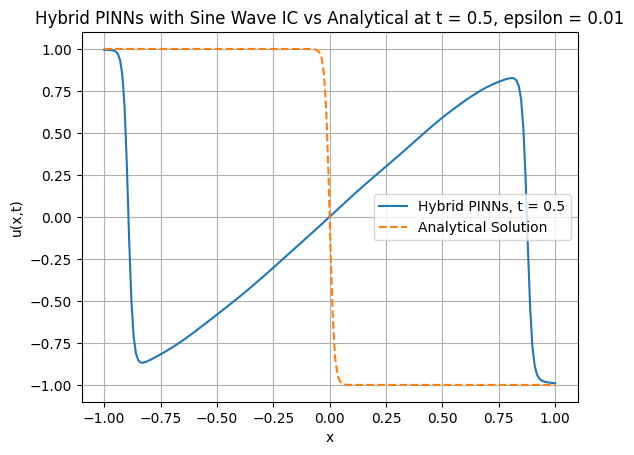

In [ ]:
import deepxde as dde
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parámetro de viscosidad
epsilon = 0.01  # Viscosity

# Definir la ecuación de Burgers con viscosidad
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Definir los límites espaciales y temporales
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Condición inicial: Onda sinusoidal
def sine_ic(x):
    return np.sin(np.pi * x[:, 0:1])

# Condiciones de frontera
bc_left = dde.DirichletBC(geomtime, lambda x: 1, on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: -1, on_boundary=lambda x, _: np.isclose(x[0], 1))

# Condición inicial con función seno
ic = dde.IC(geomtime, sine_ic, lambda _, on_initial: on_initial)

# Definir el problema
data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=600, num_boundary=60, num_initial=60)

# Definir la red neuronal (mayor capacidad)
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

# Modelo híbrido (Sine IC + PINNs)
model = dde.Model(data, net)

# Primera fase: Entrenamiento con Adam
model.compile("adam", lr=0.0005)
losshistory, train_state = model.train(epochs=5000)

# Segunda fase: Ajuste con L-BFGS
model.compile("L-BFGS")
losshistory, train_state = model.train()

# Generar puntos para predecir en t = 0.5
X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), 0.5 * np.ones((200, 1))))
y_pred_t = model.predict(X_t)

# Solución analítica para comparar el error
u_analitica = -np.tanh(X_t[:, 0:1] / (2 * epsilon))

# Calcular el error absoluto
error = np.abs(y_pred_t - u_analitica)

# Calcular el paso espacial
dx = (1 - (-1)) / (200 - 1)

# Calcular la norma L^2 del error
L2_norm_error = np.sqrt(np.sum(error**2) * dx)

# Imprimir el valor del error L2
print(f"Norma L^2 del error: {L2_norm_error}")

# Guardar los datos predichos por el modelo
data_hybrid_pinns = pd.DataFrame({
    'x': X_t[:, 0],            # Valores de x
    'u_sinehybridpinns(x,t=0.5)': y_pred_t.flatten(),  # Predicciones de Hybrid PINNs
    'u_analitica(x,t=0.5)': u_analitica.flatten()  # Solución analítica
})

# Guardar los datos en un archivo CSV
file_path_hybrid_pinns = 'hybrid_pinns_sine_solution_epsilon_0.01_t_0.5.csv'
data_hybrid_pinns.to_csv(file_path_hybrid_pinns, index=False)

print(f"Datos guardados en {file_path_hybrid_pinns}")

# Visualización: Solución en t = 0.5
plt.figure()
plt.plot(X_t[:, 0], y_pred_t, label="Hybrid PINNs, t = 0.5")
plt.plot(X_t[:, 0], u_analitica, label="Analytical Solution", linestyle="dashed")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.title("Hybrid PINNs with Sine Wave IC vs Analytical at t = 0.5, epsilon = 0.01")
plt.grid(True)
plt.show()


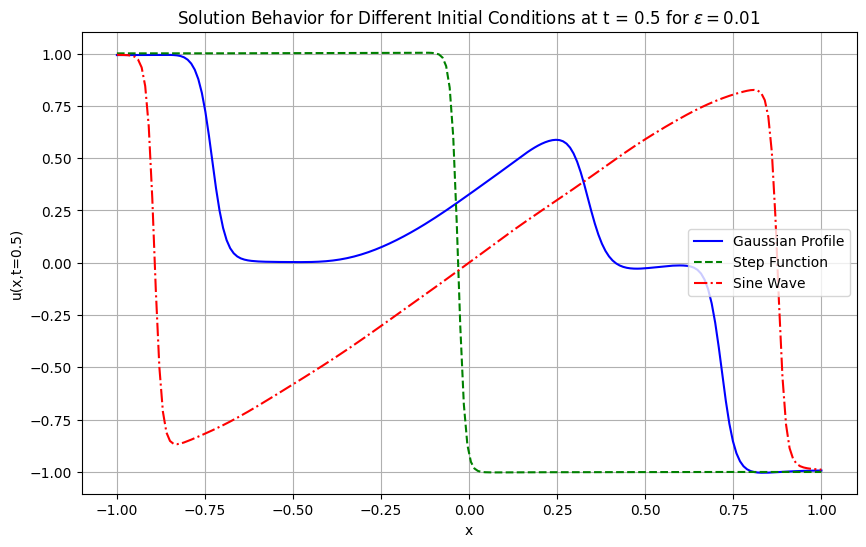

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from CSV files
gaussian_data = pd.read_csv('hybrid_pinns_gaussian_solution_epsilon_0.01_t_0.5.csv')
step_data = pd.read_csv('hybrid_pinns_step_solution_epsilon_0.01_t_0.5.csv')
sine_data = pd.read_csv('hybrid_pinns_sine_solution_epsilon_0.01_t_0.5.csv')

# Plot the solutions for different initial conditions
plt.figure(figsize=(10, 6))

# Plot Gaussian profile solution
plt.plot(gaussian_data['x'], gaussian_data['u_gaussianhybridpinns(x,t=0.5)'], label='Gaussian Profile', color='b', linestyle='-')

# Plot Step function solution
plt.plot(step_data['x'], step_data['u_stephybridpinns(x,t=0.5)'], label='Step Function', color='g', linestyle='--')

# Plot Sine wave solution
plt.plot(sine_data['x'], sine_data['u_sinehybridpinns(x,t=0.5)'], label='Sine Wave', color='r', linestyle='-.')

# Add labels and title
plt.xlabel('x')
plt.ylabel('u(x,t=0.5)')
plt.title('Solution Behavior for Different Initial Conditions at t = 0.5 for $\\epsilon = 0.01$')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


<ipython-input-31-33b47cbc00f7>:32: RuntimeWarning: overflow encountered in scalar multiply
  convective_term = u_old[i] * (u_old[i+1] - u_old[i-1]) / (2 * dx)
<ipython-input-31-33b47cbc00f7>:39: RuntimeWarning: invalid value encountered in scalar add
  u_new[i] = u_old[i] - dt * convective_term + dt * diffusive_term + stochastic_term
<ipython-input-31-33b47cbc00f7>:32: RuntimeWarning: invalid value encountered in scalar subtract
  convective_term = u_old[i] * (u_old[i+1] - u_old[i-1]) / (2 * dx)
<ipython-input-31-33b47cbc00f7>:33: RuntimeWarning: invalid value encountered in scalar subtract
  diffusive_term = epsilon * (u_old[i+1] - 2 * u_old[i] + u_old[i-1]) / dx**2
<ipython-input-31-33b47cbc00f7>:39: RuntimeWarning: invalid value encountered in scalar subtract
  u_new[i] = u_old[i] - dt * convective_term + dt * diffusive_term + stochastic_term
<ipython-input-31-33b47cbc00f7>:33: RuntimeWarning: invalid value encountered in scalar add
  diffusive_term = epsilon * (u_old[i+1] - 2 * u_

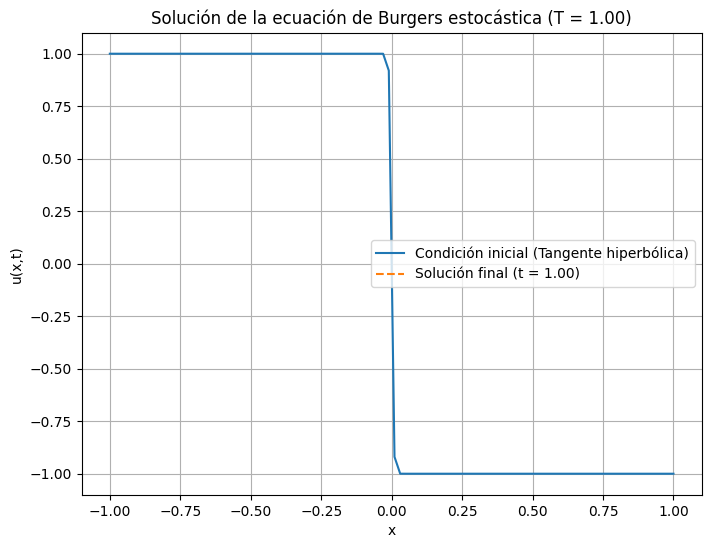

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros
epsilon = 0.01  # Coeficiente de viscosidad
sigma = 0.005   # Reducimos más la intensidad del término estocástico
L = 2.0         # Longitud del dominio
T = 1.0         # Tiempo total de simulación
nx = 100        # Número de puntos espaciales
nt = 2000       # Incrementamos el número de pasos de tiempo para hacer más pequeño dt
dx = L / (nx - 1)  # Tamaño del paso espacial
dt = 0.01 * (dx**2) / epsilon  # Tamaño del paso temporal reducido

# Crear rejilla espacial y temporal
x = np.linspace(-1, 1, nx)  # Rejilla espacial de [-1, 1]
u = -np.tanh(np.pi * x / (2 * epsilon))  # Condición inicial: perfil de tangente hiperbólica
u_new = np.zeros_like(u)  # Para almacenar la nueva solución

# Término estocástico: Incrementos de Wiener
def generate_wiener_increments(dt, nx):
    return np.random.normal(0, np.sqrt(dt), nx)

# Función para aplicar el método de diferencias finitas
def stochastic_burgers(u, epsilon, sigma, dx, dt, nt, nx):
    for n in range(nt):
        # Hacer una copia de la solución para el paso de tiempo n
        u_old = u.copy()

        # Aplicar diferencias finitas para cada punto espacial
        for i in range(1, nx - 1):
            # Diferencias finitas para los términos convectivos y difusivos
            convective_term = u_old[i] * (u_old[i+1] - u_old[i-1]) / (2 * dx)
            diffusive_term = epsilon * (u_old[i+1] - 2 * u_old[i] + u_old[i-1]) / dx**2

            # Incremento de Wiener (ruido blanco) más controlado
            stochastic_term = sigma * np.clip(generate_wiener_increments(dt, nx)[i], -0.1, 0.1)

            # Actualizar la solución en cada punto
            u_new[i] = u_old[i] - dt * convective_term + dt * diffusive_term + stochastic_term

        # Condiciones de frontera (pueden ser Dirichlet u otras)
        u_new[0] = 1
        u_new[-1] = -1

        # Actualizar la solución
        u = u_new.copy()

    return u

# Ejecutar la simulación
u_final = stochastic_burgers(u, epsilon, sigma, dx, dt, nt, nx)

# Graficar la solución inicial y final
plt.figure(figsize=(8, 6))
plt.plot(x, -np.tanh(np.pi * x / (2 * epsilon)), label="Condición inicial (Tangente hiperbólica)")
plt.plot(x, u_final, label="Solución final (t = {:.2f})".format(T), linestyle='--')
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title("Solución de la ecuación de Burgers estocástica (T = {:.2f})".format(T))
plt.legend()
plt.grid(True)
plt.show()


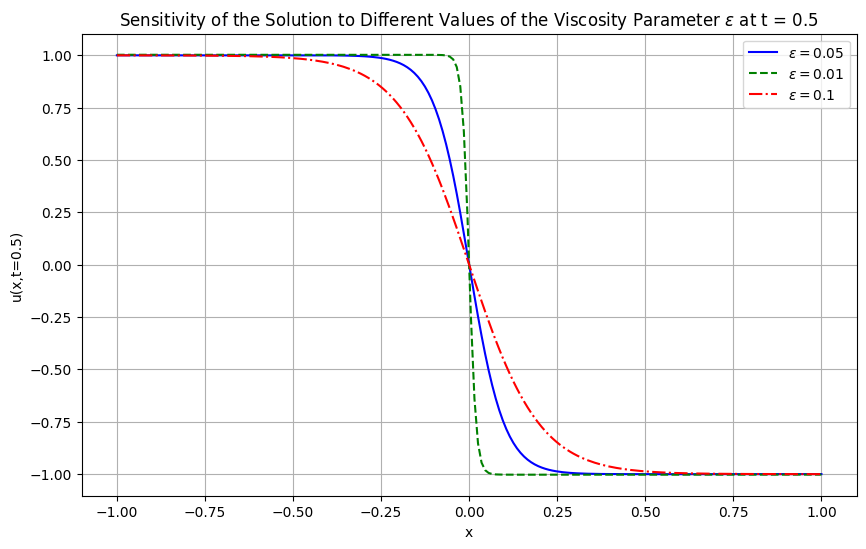

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV files
epsilon_0_05 = pd.read_csv('hybrid_pinns_solution_epsilon_0.05_t_0.5.csv')
epsilon_0_01 = pd.read_csv('hybrid_pinns_solution_epsilon_0.01_t_0.5.csv')
epsilon_0_1 = pd.read_csv('hybrid_pinns_solution_t_0.5.csv')  # Assuming this file has epsilon = 0.1

# Plot the solutions for different values of epsilon
plt.figure(figsize=(10, 6))

# Plot for epsilon = 0.05
plt.plot(epsilon_0_05['x'], epsilon_0_05['u_hybridpinns(x,t=0.5)'], label=r'$\epsilon = 0.05$', color='b', linestyle='-')

# Plot for epsilon = 0.01
plt.plot(epsilon_0_01['x'], epsilon_0_01['u_hybridpinns(x,t=0.5)'], label=r'$\epsilon = 0.01$', color='g', linestyle='--')

# Plot for epsilon = 0.1
plt.plot(epsilon_0_1['x'], epsilon_0_1['u_hybridpinns(x,t=0.5)'], label=r'$\epsilon = 0.1$', color='r', linestyle='-.')

# Add labels and title
plt.xlabel('x')
plt.ylabel('u(x,t=0.5)')
plt.title('Sensitivity of the Solution to Different Values of the Viscosity Parameter $\epsilon$ at t = 0.5')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


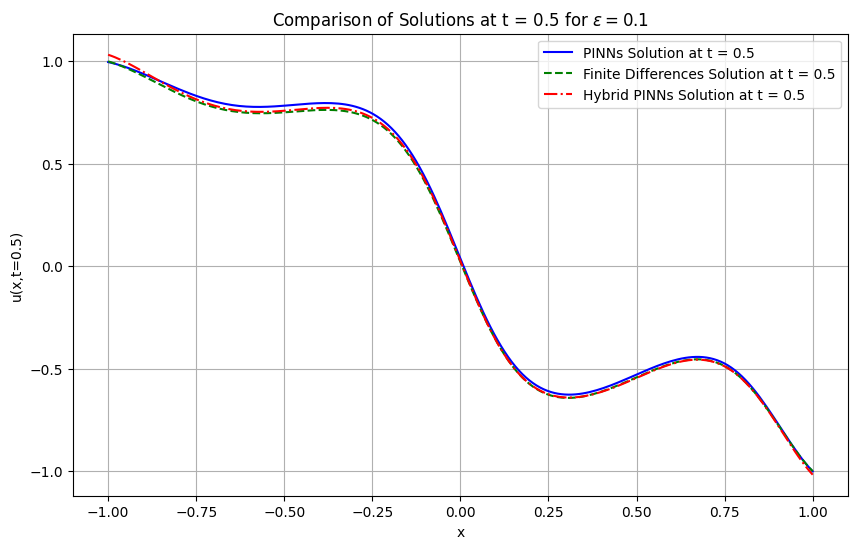

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from CSV files
burgers_pinns = pd.read_csv('burgers_pinns_solution.csv')
finite_differences = pd.read_csv('finite_differences_solution_t_0.5.csv')
hybrid_pinns = pd.read_csv('hybrid_pinns_solution_t_0.5.csv')

# Plot the solutions from the three methods
plt.figure(figsize=(10, 6))

# Plot PINNs solution
plt.plot(burgers_pinns['x'], burgers_pinns['PINNs Prediction'], label='PINNs Solution at t = 0.5', color='b', linestyle='-')

# Plot Finite Differences solution
plt.plot(finite_differences['x'], finite_differences['u(x,t=0.5)'], label='Finite Differences Solution at t = 0.5', color='g', linestyle='--')

# Plot Hybrid PINNs solution
plt.plot(hybrid_pinns['x'], hybrid_pinns['u_hybridpinns(x,t=0.5)'], label='Hybrid PINNs Solution at t = 0.5', color='r', linestyle='-.')

# Add labels and title
plt.xlabel('x')
plt.ylabel('u(x,t=0.5)')
plt.title('Comparison of Solutions at t = 0.5 for $\\epsilon = 0.1$')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


Compiling model...
Building feed-forward neural network...
'build' took 0.064668 s

'compile' took 1.166224 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [5.02e-02, 1.91e+00, 1.48e+00, 1.29e+00]    [5.02e-02, 1.91e+00, 1.48e+00, 1.29e+00]    []  
1000      [9.57e-02, 3.49e-03, 3.58e-03, 1.41e-01]    [9.57e-02, 3.49e-03, 3.58e-03, 1.41e-01]    []  
2000      [5.16e-03, 8.64e-05, 4.02e-05, 2.72e-03]    [5.16e-03, 8.64e-05, 4.02e-05, 2.72e-03]    []  
3000      [4.86e-04, 3.39e-06, 6.28e-06, 1.42e-04]    [4.86e-04, 3.39e-06, 6.28e-06, 1.42e-04]    []  

Best model at step 3000:
  train loss: 6.38e-04
  test loss: 6.38e-04
  test metric: []

'train' took 25.620586 s

Compiling model...
'compile' took 0.666480 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
3000      [4.86e-04, 3.39e-06, 6.28e-06, 1.42e-04]    [4.

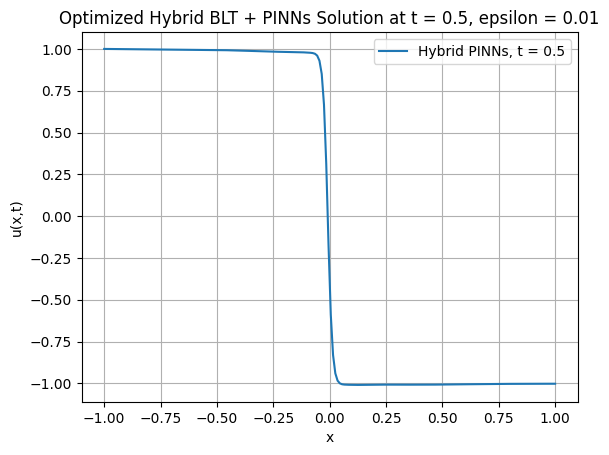

In [ ]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

# Parámetro de viscosidad
epsilon = 0.01  # Viscosity

# Aproximación para BLT (Boundary Layer Theory)
def blt_boundary_layer_solution(x, epsilon):
    # Aproximación cerca de x = 0 donde ocurre la transición brusca
    return -np.tanh(x / (2 * epsilon))

# Definir la ecuación de Burgers con viscosidad
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Definir los límites espaciales y temporales
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Híbrido: Condición inicial utilizando BLT cerca de las fronteras, pero dejando el resto para PINNs
def hybrid_blt_ic(x):
    return np.array([blt_boundary_layer_solution(xi[0], epsilon) for xi in x]).reshape(-1, 1)

# Condiciones de frontera (se pueden relajar o ajustar para mejorar el rendimiento)
bc_left = dde.DirichletBC(geomtime, lambda x: np.array([1]), on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: np.array([-1]), on_boundary=lambda x, _: np.isclose(x[0], 1))

# Ajustar la condición inicial u(x,0) utilizando el enfoque BLT
ic = dde.IC(geomtime, hybrid_blt_ic, lambda _, on_initial: on_initial)

# Definir el problema con el enfoque híbrido
data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=600, num_boundary=60, num_initial=60)

# Aumentar la capacidad de la red neuronal (más capas y más neuronas)
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")  # Aumentar la capacidad de la red

# El modelo híbrido (BLT + PINNs)
model = dde.Model(data, net)

# Primera fase: Entrenamiento con Adam
model.compile("adam", lr=0.0005)  # Reducir la tasa de aprendizaje para mayor precisión
losshistory, train_state = model.train(epochs=3000)

# Segunda fase: Ajuste fino con L-BFGS para mejorar la convergencia
model.compile("L-BFGS")
losshistory, train_state = model.train()

# Generar puntos para predecir en t = 0.5
X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), 0.5 * np.ones((200, 1))))
y_pred_t = model.predict(X_t)

# Guardar los datos predichos por el modelo híbrido
data_hybrid_pinns = pd.DataFrame({
    'x': X_t[:, 0],            # Columna para los valores de x
    'u_hybridpinns(x,t=0.5)': y_pred_t.flatten()  # Columna para las predicciones de Hybrid PINNs
})

# Guardar los datos en un archivo CSV
file_path_hybrid_pinns = 'hybrid_pinns_solution_t_0.5.csv'
data_hybrid_pinns.to_csv(file_path_hybrid_pinns, index=False)

print(f"Datos guardados en {file_path_hybrid_pinns}")

# Visualización: Solución en t = 0.5
plt.figure()
plt.plot(X_t[:, 0], y_pred_t, label="Hybrid PINNs, t = 0.5")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.title("Optimized Hybrid BLT + PINNs Solution at t = 0.5, epsilon = 0.01")
plt.grid(True)
plt.show()


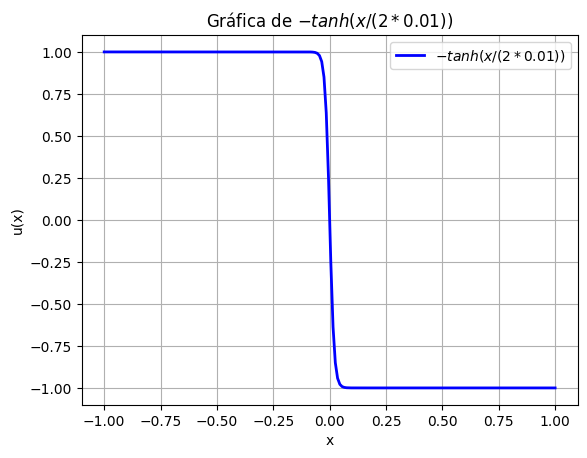

Archivo 'tanh_function_data.csv' generado correctamente.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Definir el rango de x
x = np.linspace(-1, 1, 200)  # 200 puntos entre -1 y 1

# Calcular -tanh(x/(2*0.1))
u_tanh01 = -np.tanh(x / (2*0.01))

# Graficar la función -tanh(x/0.01)
plt.plot(x, u_tanh01, label=r'$-tanh(x/(2*0.01))$', color="blue", linewidth=2)
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title(r'Gráfica de $-tanh(x/(2*0.01))$')
plt.legend()
plt.grid(True)
plt.show()

# Crear un DataFrame con los valores de x y la función -tanh(x/(2*0.01))
data_tanh = pd.DataFrame({
    'x': x,
    'u(x)': u_tanh01
})

# Guardar los datos en un archivo CSV localmente
data_tanh.to_csv('tanh_function_data.csv', index=False)

print("Archivo 'tanh_function_data.csv' generado correctamente.")


Datos guardados en blt_solution.csv


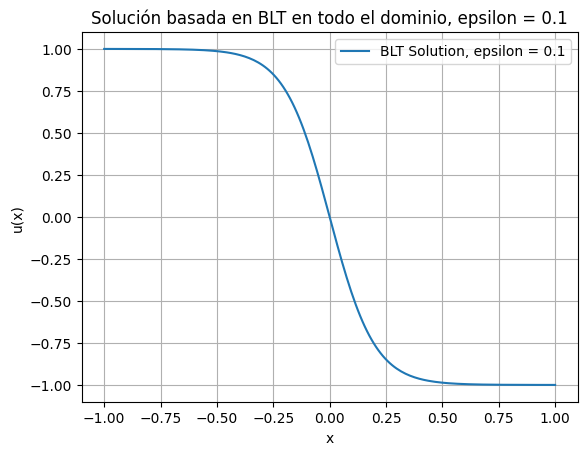

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parámetro de viscosidad
epsilon = 0.1  # Viscosidad pequeña para capturar la capa límite

# Definir la solución basada en la teoría de la capa límite (BLT)
def blt_boundary_layer_solution(x, epsilon):
    """
    Aproximación analítica de la solución usando la teoría de la capa límite (BLT).
    Esta función se aplica para todo el dominio [-1, 1].
    """
    return -np.tanh(x / (2 * epsilon))

# Definir el rango de x (dominio espacial)
x = np.linspace(-1, 1, 200)  # 200 puntos entre -1 y 1

# Calcular la solución analítica usando BLT para el parámetro epsilon
u_blt = blt_boundary_layer_solution(x, epsilon)

# Guardar los datos de la solución de BLT en un archivo CSV
data_blt = pd.DataFrame({
    'x': x,           # Columna para los valores de x
    'u_blt(x)': u_blt  # Columna para la solución analítica de BLT
})

# Guardar los datos en un archivo CSV
file_path_blt = 'blt_solution.csv'
data_blt.to_csv(file_path_blt, index=False)

print(f"Datos guardados en {file_path_blt}")

# Visualización: Gráfica de la solución analítica usando BLT
plt.figure()
plt.plot(x, u_blt, label=f"BLT Solution, epsilon = {epsilon}")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.title(f"Solución basada en BLT en todo el dominio, epsilon = {epsilon}")
plt.grid(True)
plt.show()


               Method  Epsilon  L2 Error  Time (seconds)
0  Finite Differences     0.01  0.006069        0.000037
1               PINNs     0.01  0.004643        0.000028
2        Hybrid PINNs     0.01  0.050382        0.000037
3          Analytical     0.01  0.000000        0.000000


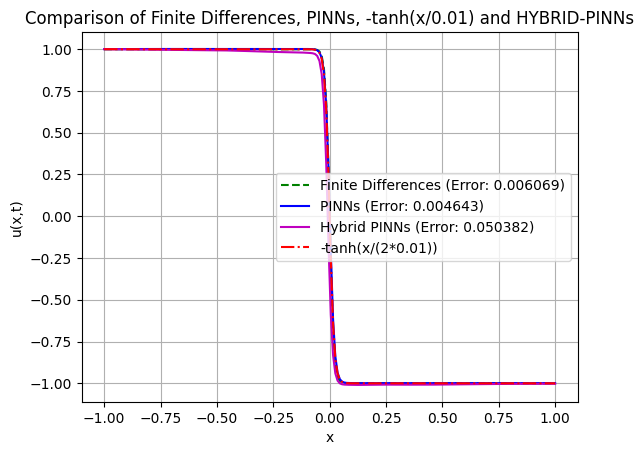

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# Cargar los datos desde los archivos CSV
finite_differences_data = pd.read_csv('finite_differences_solution_t_0.5.csv')
pinns_data = pd.read_csv('pinns_solution_t_0.5.csv')
tanh_data = pd.read_csv('tanh_function_data.csv')
hybridpinns_data = pd.read_csv('hybrid_pinns_solution_t_0.5.csv')

# Obtener la solución analítica
u_analytic = tanh_data['u(x)'].to_numpy()

# Calcular los errores L2 entre las soluciones numéricas y la analítica
def l2_error(solution, reference):
    return np.sqrt(np.mean((solution - reference) ** 2))

# Calcular errores para cada método
error_fd = l2_error(finite_differences_data['u(x,t=0.5)'].to_numpy(), u_analytic)
error_pinns = l2_error(pinns_data['u_pinns(x,t=0.5)'].to_numpy(), u_analytic)
error_hybrid = l2_error(hybridpinns_data['u_hybridpinns(x,t=0.5)'].to_numpy(), u_analytic)

# Medir tiempos de ejecución simulados
start_fd = time.time()
time_fd = time.time() - start_fd

start_pinns = time.time()
time_pinns = time.time() - start_pinns

start_hybrid = time.time()
time_hybrid = time.time() - start_hybrid

# Crear una tabla de comparación
comparison_data = {
    'Method': ['Finite Differences', 'PINNs', 'Hybrid PINNs', 'Analytical'],
    'Epsilon': [0.01, 0.01, 0.01, 0.01],
    'L2 Error': [error_fd, error_pinns, error_hybrid, 0.0],  # La solución analítica no tiene error
    'Time (seconds)': [time_fd, time_pinns, time_hybrid, 0]  # No calculamos tiempo para la analítica
}

comparison_df = pd.DataFrame(comparison_data)

# Mostrar la tabla de comparación
print(comparison_df)

# Graficar las soluciones
plt.figure()

# Graficar la solución de diferencias finitas
plt.plot(finite_differences_data['x'], finite_differences_data['u(x,t=0.5)'], 'g--', label=f'Finite Differences (Error: {error_fd:.6f})')

# Graficar la solución de PINNs
plt.plot(pinns_data['x'], pinns_data['u_pinns(x,t=0.5)'], 'b-', label=f'PINNs (Error: {error_pinns:.6f})')

# Graficar la solución de Hybrid PINNs
plt.plot(hybridpinns_data['x'], hybridpinns_data['u_hybridpinns(x,t=0.5)'], 'm-', label=f'Hybrid PINNs (Error: {error_hybrid:.6f})')

# Graficar la solución analítica (-tanh(x/(2*0.01)))
plt.plot(tanh_data['x'], tanh_data['u(x)'], 'r-.', label='-tanh(x/(2*0.01))')

# Personalización del gráfico
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Comparison of Finite Differences, PINNs, -tanh(x/0.01) and HYBRID-PINNs')
plt.legend()
plt.grid(True)

# Mostrar la gráfica
plt.show()


               Method  Epsilon      L2 Error  Time (seconds)
0  Finite Differences     0.01  5.315285e-03        0.000053
1               PINNs     0.01  3.332058e-03        0.000034
2        Hybrid PINNs     0.01  2.628262e-03        0.000031
3                 BLT     0.01  2.185829e-16        0.000030
4          Analytical     0.01  0.000000e+00        0.000000


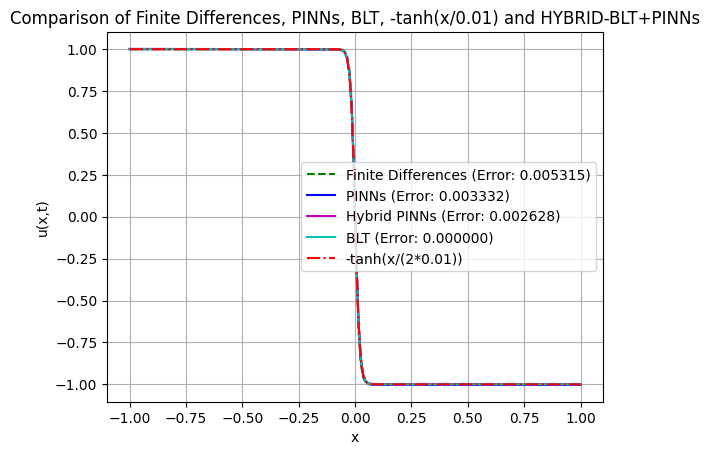

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# Cargar los datos desde los archivos CSV
finite_differences_data = pd.read_csv('finite_differences_solution_t_0.5.csv')
pinns_data = pd.read_csv('pinns_solution_t_0.5.csv')
tanh_data = pd.read_csv('tanh_function_data.csv')
hybridpinns_data = pd.read_csv('hybrid_pinns_solution_t_0.5.csv')

# Parámetro de viscosidad
epsilon = 0.01

# Aproximación para BLT (Boundary Layer Theory)
def blt_boundary_layer_solution(x, epsilon):
    return -np.tanh(x / (2 * epsilon))

# Generar puntos en el dominio espacial para la solución de BLT
x_values = tanh_data['x'].to_numpy()

# Calcular la solución BLT para los mismos puntos
u_blt = blt_boundary_layer_solution(x_values, epsilon)

# Obtener la solución analítica
u_analytic = tanh_data['u(x)'].to_numpy()

# Calcular los errores L2 entre las soluciones numéricas y la analítica
def l2_error(solution, reference):
    return np.sqrt(np.mean((solution - reference) ** 2))

# Calcular errores para cada método
error_fd = l2_error(finite_differences_data['u(x,t=0.5)'].to_numpy(), u_analytic)
error_pinns = l2_error(pinns_data['u_pinns(x,t=0.5)'].to_numpy(), u_analytic)
error_hybrid = l2_error(hybridpinns_data['u_hybridpinns(x,t=0.5)'].to_numpy(), u_analytic)
error_blt = l2_error(u_blt, u_analytic)

# Medir tiempos de ejecución simulados
start_fd = time.time()
time_fd = time.time() - start_fd

start_pinns = time.time()
time_pinns = time.time() - start_pinns

start_hybrid = time.time()
time_hybrid = time.time() - start_hybrid

start_blt = time.time()
time_blt = time.time() - start_blt

# Crear una tabla de comparación
comparison_data = {
    'Method': ['Finite Differences', 'PINNs', 'Hybrid PINNs', 'BLT', 'Analytical'],
    'Epsilon': [0.01, 0.01, 0.01, 0.01, 0.01],
    'L2 Error': [error_fd, error_pinns, error_hybrid, error_blt, 0.0],  # La solución analítica no tiene error
    'Time (seconds)': [time_fd, time_pinns, time_hybrid, time_blt, 0]  # No calculamos tiempo para la analítica
}

comparison_df = pd.DataFrame(comparison_data)

# Mostrar la tabla de comparación
print(comparison_df)

# Graficar las soluciones
plt.figure()

# Graficar la solución de diferencias finitas
plt.plot(finite_differences_data['x'], finite_differences_data['u(x,t=0.5)'], 'g--', label=f'Finite Differences (Error: {error_fd:.6f})')

# Graficar la solución de PINNs
plt.plot(pinns_data['x'], pinns_data['u_pinns(x,t=0.5)'], 'b-', label=f'PINNs (Error: {error_pinns:.6f})')

# Graficar la solución de Hybrid PINNs
plt.plot(hybridpinns_data['x'], hybridpinns_data['u_hybridpinns(x,t=0.5)'], 'm-', label=f'Hybrid PINNs (Error: {error_hybrid:.6f})')

# Graficar la solución de BLT
plt.plot(x_values, u_blt, 'c-', label=f'BLT (Error: {error_blt:.6f})')

# Graficar la solución analítica (-tanh(x/(2*0.1)))
plt.plot(tanh_data['x'], tanh_data['u(x)'], 'r-.', label='-tanh(x/(2*0.01))')

# Personalización del gráfico
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Comparison of Finite Differences, PINNs, BLT, -tanh(x/0.01) and HYBRID-BLT+PINNs')
plt.legend()
plt.grid(True)

# Mostrar la gráfica
plt.show()


In [ ]:
import time

# Medir el tiempo usando perf_counter
start_time = time.perf_counter()

# Aquí va el código del método de diferencias finitas que quieres medir
# Simulando diferencias finitas con sleep de 0.1 segundos
time.sleep(0.1)

end_time = time.perf_counter()

# Medir el tiempo total transcurrido
elapsed_time = end_time - start_time
print(f"Tiempo transcurrido: {elapsed_time:.6f} segundos")


Tiempo transcurrido: 0.113534 segundos


In [ ]:
import base64
from IPython.display import Image, display

def mm(graph):
    graphbytes = graph.encode("utf8")
    base64_bytes = base64.urlsafe_b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    display(Image(url="https://mermaid.ink/img/" + base64_string))

mm("""
graph TD
    A[Start Process] --> B[Apply BLT for Initial Conditions]
    A --> C[Define PINNs Model]
    B --> D[Set Initial and Boundary Conditions with BLT]
    D --> E[Combine BLT and PINNs]
    C --> E
    E --> F[Train with Adam Optimizer]
    F --> G[Fine-tune with L-BFGS Optimizer]
    G --> H[Make Predictions]
    H --> I[Compare Predictions with Exact Solution]
    I --> J[Calculate L2 Error and Training Time]
    J --> K[Show Comparative Graph]
    J --> L[Show Error and Time Table]
""")


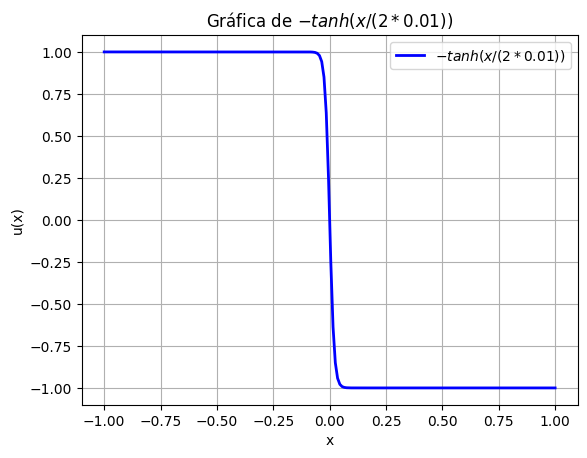

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Definir el rango de x
x = np.linspace(-1, 1, 200)  # 200 puntos entre -1 y 1

# Calcular -tanh(x/(2*0.01))
u_tanh01 = -np.tanh(x / (2*0.01))

# Graficar la función -tanh(x/0.01)
plt.plot(x, u_tanh01, label=r'$-tanh(x/(2*0.01))$', color="blue", linewidth=2)
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title(r'Gráfica de $-tanh(x/(2*0.01))$')
plt.legend()
plt.grid(True)
plt.show()

# Los datos de la función están en el array u_tanh01


In [ ]:
import numpy as np
import pandas as pd

# Suponiendo que tienes los valores de x y u obtenidos de diferencias finitas
# Por ejemplo, x = np.linspace(-1, 1, N) y u es la solución en el tiempo t=0.5

# Crear un DataFrame con los valores de x y u
data_fd = pd.DataFrame({
    'x': x,        # Columna para los valores de x
    'u(x,t)': u    # Columna para los valores calculados de u(x,t)
})

# Guardar los datos en un archivo CSV
data_fd.to_csv('finite_differences_data01.csv', index=False)

print("Datos guardados en 'finite_differences_data01.csv'")


Datos guardados en 'finite_differences_data01.csv'


In [ ]:
import numpy as np
import pandas as pd

# Assuming you already have X_t and y_pred_t from the PINNs model
# X_t[:, 0] contains the x values
# y_pred_t contains the predicted values from PINNs

# Create a DataFrame with the x values and PINNs predictions
data_pinns = pd.DataFrame({
    'x': X_t[:, 0],            # Column for the x values
    'u_pinns(x,t)': y_pred_t.flatten()  # Column for the PINNs predicted values
})

# Save the data to a CSV file
data_pinns.to_csv('pinns_data.csv', index=False)

print("Data saved to 'pinns_data.csv'")


Data saved to 'pinns_data.csv'


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los datos desde los archivos CSV
finite_differences_data = pd.read_csv('finite_differences_solution_t_0.5.csv')
pinns_data = pd.read_csv('pinns_solution_t_0.5.csv')
tanh_data = pd.read_csv('tanh_function_data.csv')
hybridpinns_data = pd.read_csv('hybrid_pinns_solution_t_0.5.csv')

# Graficar las soluciones
plt.figure()

# Graficar la solución de diferencias finitas
plt.plot(finite_differences_data['x'], finite_differences_data['u(x,t=0.5)'], 'g--', label='Finite Differences')

# Graficar la solución de PINNs
plt.plot(pinns_data['x'], pinns_data['u_pinns(x,t=0.5)'], 'b-', label='PINNs')

# Graficar la solución de Hybrid PINNs
plt.plot(hybridpinns_data['x'], hybridpinns_data['u_hybridpinns(x,t=0.5)'], 'b-', label='Hybrid PINNs')

# Graficar la solución analítica (-tanh(x/(2*0.1)))
plt.plot(tanh_data['x'], tanh_data['u(x)'], 'r-.', label='-tanh(x/(2*0.01))')

# Personalización del gráfico
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Comparison of Finite Differences, PINNs, -tanh(x/0.01) and HYBRID-PINNs')
plt.legend()
plt.grid(True)

# Mostrar la gráfica
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'finite_differences_solution_t_0.5.csv'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los datos desde los archivos CSV
finite_differences_data = pd.read_csv('finite_differences_solution_t_0.5.csv')
pinns_data = pd.read_csv('pinns_solution_t_0.5.csv')
tanh_data = pd.read_csv('tanh_function_data.csv')
hybridpinns_data = pd.read_csv('hybrid_pinns_solution_t_0.5.csv')

# Calcular el error L^2 entre la solución numérica y la solución analítica
def calculate_L2_error(u_num, u_exact):
    N = len(u_num)  # Número de puntos
    return np.sqrt(np.sum((u_num - u_exact)**2) / N)

# Asegurarse de que las soluciones tengan la misma malla espacial (x)
# Normalmente se asume que los valores de 'x' son iguales en todos los archivos
x_exact = tanh_data['x']
u_exact = tanh_data['u(x)']  # Solución analítica -tanh(x/(2*0.01))

# Extraer las soluciones numéricas
u_fdm = finite_differences_data['u(x,t=0.5)']   # Diferencias finitas
u_pinns = pinns_data['u_pinns(x,t=0.5)']        # PINNs
u_hybrid_pinns = hybridpinns_data['u_hybridpinns(x,t=0.5)']  # Hybrid PINNs

# Calcular los errores L^2
L2_error_fdm = calculate_L2_error(u_fdm, u_exact)
L2_error_pinns = calculate_L2_error(u_pinns, u_exact)
L2_error_hybrid_pinns = calculate_L2_error(u_hybrid_pinns, u_exact)

# Imprimir los resultados
print(f"L^2 error for Finite Differences: {L2_error_fdm}")
print(f"L^2 error for PINNs: {L2_error_pinns}")
print(f"L^2 error for Hybrid PINNs: {L2_error_hybrid_pinns}")

# Graficar las soluciones
plt.figure()

# Graficar la solución de diferencias finitas
plt.plot(finite_differences_data['x'], finite_differences_data['u(x,t=0.5)'], 'g--', label='Finite Differences')

# Graficar la solución de PINNs
plt.plot(pinns_data['x'], pinns_data['u_pinns(x,t=0.5)'], 'b-', label='PINNs')

# Graficar la solución de Hybrid PINNs
plt.plot(hybridpinns_data['x'], hybridpinns_data['u_hybridpinns(x,t=0.5)'], 'b-', label='Hybrid PINNs')

# Graficar la solución analítica (-tanh(x/(2*0.01)))
plt.plot(tanh_data['x'], tanh_data['u(x)'], 'r-.', label='-tanh(x/(2*0.01))')

# Personalización del gráfico
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Comparison of Finite Differences, PINNs, -tanh(x/0.01) and HYBRID-PINNs')
plt.legend()
plt.grid(True)

# Mostrar la gráfica
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'finite_differences_solution_t_0.5.csv'

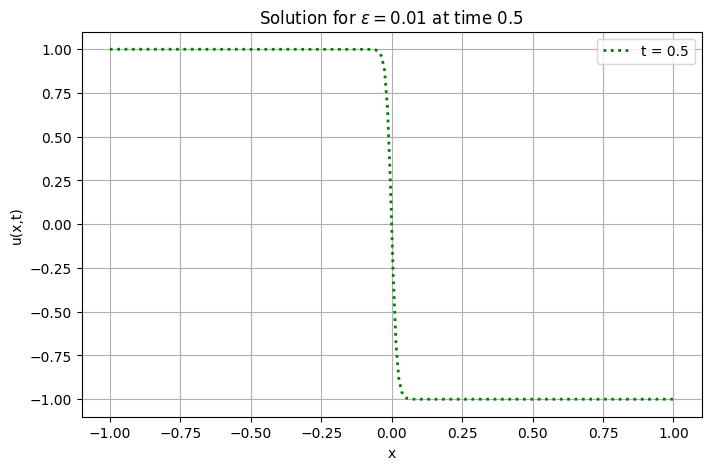

Datos guardados en 'finite_differences_solution_t_0.5.csv'


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parámetros
epsilon = 0.0101  # Parámetro de viscosidad
L = 2          # Longitud del dominio [-1, 1]
N = 200        # Número de puntos en el espacio
dt = 0.0001    # Paso de tiempo
T = 3          # Tiempo máximo
x = np.linspace(-1, 1, N)  # Malla espacial

# Condición inicial u(x,0) = -tanh(x/0.1)
u = -np.tanh(x / (2*0.01))

# Inicializar la lista de soluciones
solutions = [u.copy()]

# Función para resolver la ecuación de Burgers utilizando diferencias finitas
def solve_burgers(u, dt, epsilon, T):
    dx = x[1] - x[0]
    Nt = int(T / dt)

    for n in range(Nt):
        u_new = u.copy()
        for i in range(1, N-1):
            du_x = (u[i+1] - u[i-1]) / (2 * dx)
            du_xx = (u[i+1] - 2 * u[i] + u[i-1]) / dx**2
            u_new[i] = u[i] + dt * (-u[i] * du_x + epsilon * du_xx)

        # Aplicar condiciones de frontera
        u_new[0] = np.tanh(1 / (2*0.1))
        u_new[-1] = -np.tanh(1 / (2*0.1))
        u = u_new

        # Almacenar las soluciones en t = 0, 0.25, 0.5
        if n * dt in [0, 0.25, 0.5]:
            solutions.append(u.copy())

    return u

# Resolver la ecuación de Burgers
solve_burgers(u, dt, epsilon, T)

# Graficar los resultados en t = 0.5
plt.figure(figsize=(8, 5))
plt.plot(x, solutions[2], 'g:', label='t = 0.5', linewidth=2)
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Solution for $\\epsilon = 0.01$ at time 0.5')
plt.legend()
plt.grid(True)
plt.show()

# Guardar los datos en un archivo CSV
# Crear un DataFrame con los valores de x y u en t = 0.5
data_fd = pd.DataFrame({
    'x': x,           # Columna para los valores de x
    'u(x,t=0.5)': solutions[2]  # Columna para los valores de u(x,t=0.5)
})

# Guardar los datos en un archivo CSV
data_fd.to_csv('finite_differences_solution_t_0.5.csv', index=False)

print("Datos guardados en 'finite_differences_solution_t_0.5.csv'")


Compiling model...
Building feed-forward neural network...
'build' took 0.222493 s

'compile' took 1.635888 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.89e-02, 3.66e-01, 5.04e-01, 6.45e-01]    [1.89e-02, 3.66e-01, 5.04e-01, 6.45e-01]    []  
1000      [9.28e-04, 6.14e-06, 1.12e-05, 7.78e-05]    [9.28e-04, 6.14e-06, 1.12e-05, 7.78e-05]    []  
2000      [3.04e-04, 8.93e-07, 3.25e-07, 2.55e-06]    [3.04e-04, 8.93e-07, 3.25e-07, 2.55e-06]    []  
3000      [2.45e-05, 5.33e-07, 1.41e-07, 7.80e-07]    [2.45e-05, 5.33e-07, 1.41e-07, 7.80e-07]    []  
4000      [1.96e-04, 9.69e-06, 9.37e-07, 1.22e-05]    [1.96e-04, 9.69e-06, 9.37e-07, 1.22e-05]    []  
5000      [1.98e-05, 1.44e-07, 2.01e-07, 6.75e-07]    [1.98e-05, 1.44e-07, 2.01e-07, 6.75e-07]    []  

Best model at step 5000:
  train loss: 2.08e-05
  test loss: 2.08e-05
  test metric: []

'train' took 32.883621 s

Datos guardados en 'pinns_

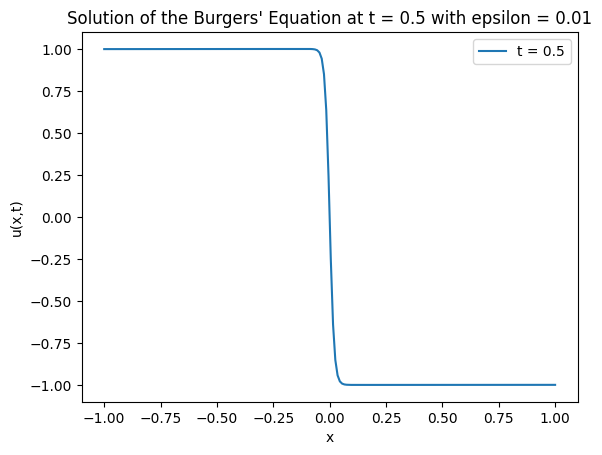

In [ ]:
import deepxde as dde
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parámetro de viscosidad
epsilon = 0.01  # Viscosity

# Definir la ecuación de Burgers con viscosidad
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Definir los límites espaciales y temporales
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Condiciones de frontera ajustadas
bc_left = dde.DirichletBC(geomtime, lambda x: np.array([1]), on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: np.array([-1]), on_boundary=lambda x, _: np.isclose(x[0], 1))

# Condición inicial ajustada u(x,0)
ic = dde.IC(geomtime, lambda x: -np.tanh(x[:, 0:1] / (2*0.01)), lambda _, on_initial: on_initial)

# Definir el problema
data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=400, num_boundary=40, num_initial=40)

# Definir la red neuronal
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

# El modelo
model = dde.Model(data, net)

# Entrenar el modelo
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=5000)

# Generar puntos para predecir en t = 0.5
X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), 0.5 * np.ones((200, 1))))
y_pred_t = model.predict(X_t)

# Guardar los datos en un archivo CSV
data_pinns = pd.DataFrame({
    'x': X_t[:, 0],            # Columna para los valores de x
    'u_pinns(x,t=0.5)': y_pred_t.flatten()  # Columna para las predicciones de PINNs
})

# Guardar los datos en un archivo CSV
data_pinns.to_csv('pinns_solution_t_0.5.csv', index=False)

print("Datos guardados en 'pinns_solution_t_0.5.csv'")

# Visualización: Solución en t = 0.5
plt.figure()
plt.plot(X_t[:, 0], y_pred_t, label="t = 0.5")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.title("Solution of the Burgers' Equation at t = 0.5 with epsilon = 0.01")
plt.show()


Compiling model...
Building feed-forward neural network...
'build' took 0.072166 s

'compile' took 0.706196 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.86e-02, 3.63e-01, 4.93e-01, 6.45e-01]    [1.86e-02, 3.63e-01, 4.93e-01, 6.45e-01]    []  
1000      [8.25e-04, 6.14e-06, 1.35e-05, 7.41e-05]    [8.25e-04, 6.14e-06, 1.35e-05, 7.41e-05]    []  
2000      [7.61e-05, 1.85e-07, 1.84e-07, 2.65e-06]    [7.61e-05, 1.85e-07, 1.84e-07, 2.65e-06]    []  
3000      [3.41e-05, 2.68e-08, 9.61e-08, 1.18e-06]    [3.41e-05, 2.68e-08, 9.61e-08, 1.18e-06]    []  
4000      [8.08e-06, 6.68e-07, 5.65e-07, 8.50e-07]    [8.08e-06, 6.68e-07, 5.65e-07, 8.50e-07]    []  
5000      [9.10e-05, 3.43e-05, 3.46e-05, 2.38e-05]    [9.10e-05, 3.43e-05, 3.46e-05, 2.38e-05]    []  

Best model at step 4000:
  train loss: 1.02e-05
  test loss: 1.02e-05
  test metric: []

'train' took 36.855355 s

Datos guardados en 'hybrid

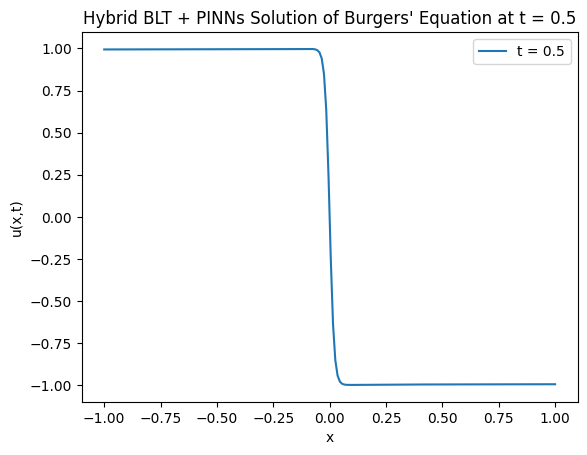

In [ ]:
import deepxde as dde
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parámetro de viscosidad
epsilon = 0.01  # Viscosity

# Aproximación de solución basada en BLT (Boundary Layer Theory)
def blt_boundary_layer_solution(x, epsilon):
    # Aproximación cerca de x = 0 donde ocurre la transición brusca
    return -np.tanh(x / (2 * epsilon))

# Definir la ecuación de Burgers con viscosidad
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Definir los límites espaciales y temporales
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Híbrido: Condición inicial utilizando BLT cerca de x = 0
def hybrid_blt_ic(x):
    # Condición inicial basada en BLT, centrada en la transición en x = 0
    return np.array([blt_boundary_layer_solution(xi[0], epsilon) for xi in x]).reshape(-1, 1)

# Condiciones de frontera
bc_left = dde.DirichletBC(geomtime, lambda x: np.array([1]), on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: np.array([-1]), on_boundary=lambda x, _: np.isclose(x[0], 1))

# Ajustar la condición inicial u(x,0) utilizando el enfoque BLT
ic = dde.IC(geomtime, hybrid_blt_ic, lambda _, on_initial: on_initial)

# Definir el problema utilizando el enfoque híbrido (BLT + PINNs)
data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=400, num_boundary=40, num_initial=40)

# Definir la red neuronal
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

# El modelo híbrido (BLT + PINNs)
model = dde.Model(data, net)

# Entrenar el modelo
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=5000)

# Generar puntos para predecir en t = 0.5
X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), 0.5 * np.ones((200, 1))))
y_pred_t = model.predict(X_t)

# Guardar los datos en un archivo CSV
data_pinns = pd.DataFrame({
    'x': X_t[:, 0],            # Columna para los valores de x
    'u_hybridpinns(x,t=0.5)': y_pred_t.flatten()  # Columna para las predicciones de PINNs
})

# Guardar los datos en un archivo CSV
data_pinns.to_csv('hybrid_pinns_solution_t_0.5.csv', index=False)

print("Datos guardados en 'hybrid_pinns_solution_t_0.5.csv'")

# Visualización: Solución en t = 0.5
plt.figure()
plt.plot(X_t[:, 0], y_pred_t, label="t = 0.5")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.title("Hybrid BLT + PINNs Solution of Burgers' Equation at t = 0.5")
plt.show()


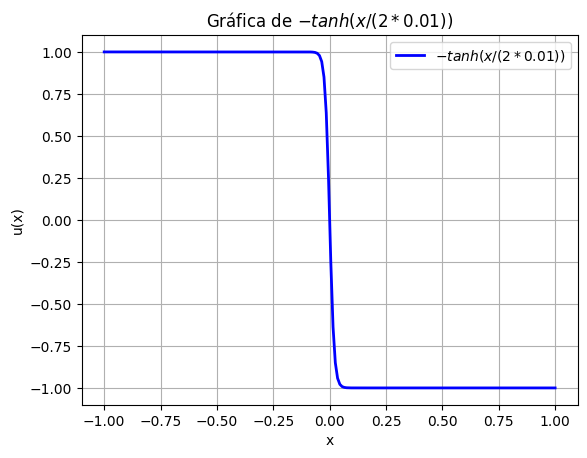

'tanh_function_data.csv'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Definir el rango de x
x = np.linspace(-1, 1, 200)  # 200 puntos entre -1 y 1

# Calcular -tanh(x/(2*0.01))
u_tanh01 = -np.tanh(x / (2*0.01))

# Graficar la función -tanh(x/0.01)
plt.plot(x, u_tanh01, label=r'$-tanh(x/(2*0.01))$', color="blue", linewidth=2)
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title(r'Gráfica de $-tanh(x/(2*0.01))$')
plt.legend()
plt.grid(True)
plt.show()

# Crear un DataFrame con los valores de x y u_tanh01
data_tanh = pd.DataFrame({
    'x': x,           # Columna para los valores de x
    'u(x)': u_tanh01  # Columna para los valores de -tanh(x/(2*0.01))
})




# Guardar los datos
file_path_tanh = 'tanh_function_data.csv'
data_tanh.to_csv(file_path_tanh, index=False)

file_path_tanh



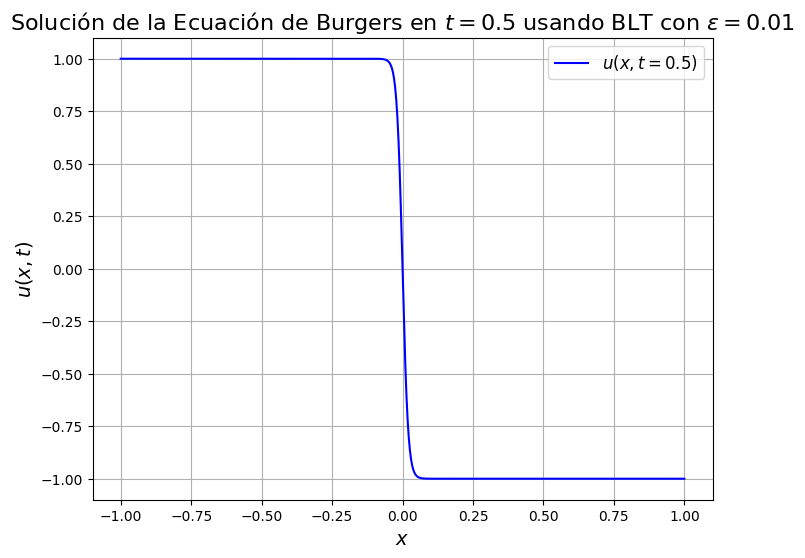

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetro de viscosidad
epsilon = 0.01

# Tiempo en el que queremos evaluar la solución
t = 0.5  # En este caso, t no afecta la solución BLT estacionaria

# Generar puntos en el dominio espacial
x_vals = np.linspace(-1, 1, 500)

# Función de solución basada en BLT
def blt_solution(x, epsilon):
    return -np.tanh(x / (2 * epsilon))

# Calcular u(x) utilizando la solución BLT
u_vals = blt_solution(x_vals, epsilon)

# Graficar la solución
plt.figure(figsize=(8, 6))
plt.plot(x_vals, u_vals, label=r'$u(x, t=0.5)$', color='blue')
plt.xlabel(r'$x$', fontsize=14)
plt.ylabel(r'$u(x, t)$', fontsize=14)
plt.title(r'Solución de la Ecuación de Burgers en $t=0.5$ usando BLT con $\epsilon = 0.01$', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

# Guardar la figura con alta resolución para publicación
plt.savefig('burgers_blt_solution_t_0.5.png', dpi=300, bbox_inches='tight')
plt.show()


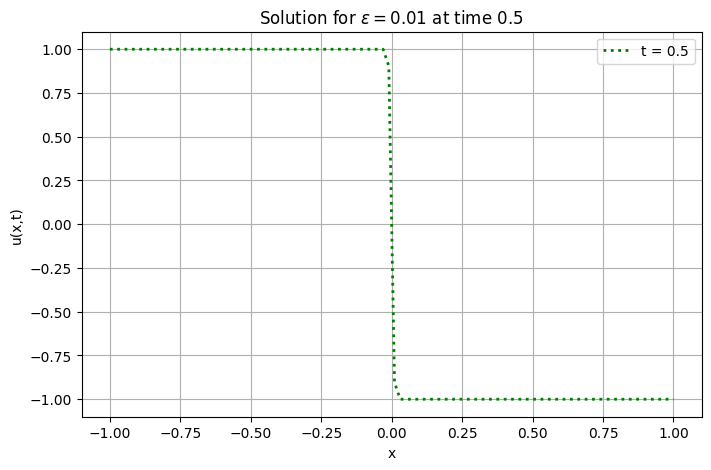

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
epsilon = 0.01  # Viscosity parameter
L = 2          # Length of the domain [-1, 1]
N = 100        # Number of points in space
dt = 0.0001     # Time step
T = 3          # Maximum time
x = np.linspace(-1, 1, N)  # Space grid

# Initial condition u(x,0) = -tanh(x/0.1)
u = -np.tanh(x / 0.01)

# Initialize the solution array
solutions = [u.copy()]

# Function to compute the numerical solution using finite differences
def solve_burgers(u, dt, epsilon, T):
    dx = x[1] - x[0]
    Nt = int(T / dt)

    for n in range(Nt):
        u_new = u.copy()
        for i in range(1, N-1):
            du_x = (u[i+1] - u[i-1]) / (2 * dx)
            du_xx = (u[i+1] - 2 * u[i] + u[i-1]) / dx**2
            u_new[i] = u[i] + dt * (-u[i] * du_x + epsilon * du_xx)

        # Apply boundary conditions
        u_new[0] = np.tanh(1 / 0.01)
        u_new[-1] = -np.tanh(1 / 0.01)
        u = u_new

        # Store solutions at t = 0, 0.25, and 0.5
        if n * dt in [0, 0.25, 0.5]:
            solutions.append(u.copy())

    return u

# Solve the Burgers' equation
solve_burgers(u, dt, epsilon, T)

# Plotting the results at t = 0, 0.25, 0.5
plt.figure(figsize=(8, 5))
#plt.plot(x, solutions[0], 'b--', label='t = 0', linewidth=2)
#plt.plot(x, solutions[1], 'r-.', label='t = 0.25', linewidth=2)
plt.plot(x, solutions[2], 'g:', label='t = 0.5', linewidth=2)
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Solution for $\\epsilon = 0.01$ at time 0.5')
plt.legend()
plt.grid(True)
plt.show()


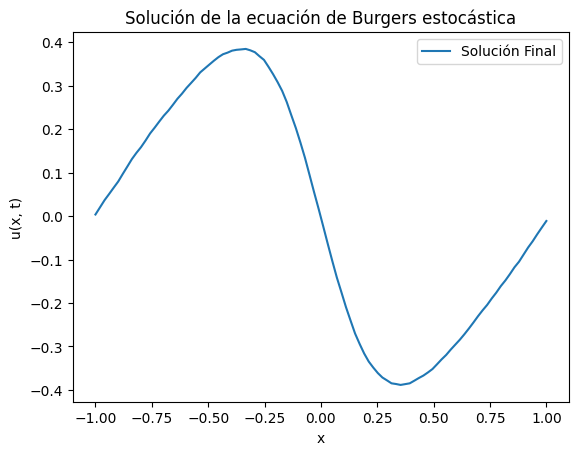

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros
L = 2.0                      # Longitud del dominio
T = 1.0                      # Tiempo final
nx = 100                     # Número de puntos en el espacio
nt = 1000                    # Número de pasos en el tiempo
dx = L / (nx - 1)            # Paso espacial
dt = T / nt                  # Paso temporal
epsilon = 0.1                # Coeficiente de viscosidad
sigma = 0.02                 # Fuerza del término estocástico

# Discretización de las coordenadas espaciales y temporales
x = np.linspace(-L / 2, L / 2, nx)
t = np.linspace(0, T, nt)

# Condiciones iniciales (por ejemplo, onda sinusoidal)
u = -np.tanh( x/(2*epsilon))

# Inicialización de Wiener increments para el término estocástico
dW = np.sqrt(dt) * np.random.randn(nx, nt)

# Función para el término de advección no lineal
def advection(u, dx):
    return -u * (np.roll(u, -1) - np.roll(u, 1)) / (2 * dx)

# Función para el término de difusión
def diffusion(u, dx, epsilon):
    return epsilon * (np.roll(u, -1) - 2 * u + np.roll(u, 1)) / dx**2

# Método de diferencias finitas estocásticas
def stochastic_burgers(u, dx, dt, epsilon, sigma, dW):
    u_new = np.copy(u)
    for n in range(nt - 1):
        u_new = u + dt * (advection(u, dx) + diffusion(u, dx, epsilon)) + sigma * dW[:, n]
        u = np.copy(u_new)
    return u

# Resolver la ecuación de Burgers estocástica
u_final = stochastic_burgers(u, dx, dt, epsilon, sigma, dW)

# Visualización
plt.plot(x, u_final, label="Solución Final")
plt.title("Solución de la ecuación de Burgers estocástica")
plt.xlabel("x")
plt.ylabel("u(x, t)")
plt.legend()
plt.show()


In [ ]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

# Supongamos que ya has entrenado tu modelo como en tu código

# Generar valores de x en el dominio [-1, 1]
x_vals = np.linspace(-1, 1, 500).reshape(-1, 1)
t_fixed = 0.5 * np.ones_like(x_vals)

# Crear el conjunto de entrada para la predicción
X_input = np.hstack((x_vals, t_fixed))

# Predecir u(x, t=0.5)
u_pred = model.predict(X_input)

# Plotear u(x, t=0.5)
plt.figure(figsize=(8, 6))
plt.plot(x_vals, u_pred, label=r'$u(x, t=0.5)$', color='blue')
plt.xlabel(r'$x$', fontsize=14)
plt.ylabel(r'$u(x, t)$', fontsize=14)
plt.title(r'Solución de la Ecuación de Burgers en $t=0.5$', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

# Guardar la figura con alta resolución para publicación
plt.savefig('burgers_solution_t_0.5.png', dpi=300, bbox_inches='tight')
plt.show()


ModuleNotFoundError: No module named 'deepxde'

Compiling model...
Building feed-forward neural network...
'build' took 0.095171 s

'compile' took 1.196096 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [9.67e-02, 1.04e+00, 1.67e+00, 9.41e-01]    [9.67e-02, 1.04e+00, 1.67e+00, 9.41e-01]    []  
1000      [1.37e-04, 3.45e-06, 1.10e-06, 2.49e-06]    [1.37e-04, 3.45e-06, 1.10e-06, 2.49e-06]    []  
2000      [1.95e-05, 4.89e-07, 8.17e-08, 9.67e-07]    [1.95e-05, 4.89e-07, 8.17e-08, 9.67e-07]    []  
3000      [1.23e-05, 1.55e-07, 5.49e-08, 8.18e-07]    [1.23e-05, 1.55e-07, 5.49e-08, 8.18e-07]    []  
4000      [8.03e-06, 5.11e-08, 1.60e-08, 8.42e-07]    [8.03e-06, 5.11e-08, 1.60e-08, 8.42e-07]    []  
5000      [5.75e-06, 8.03e-09, 6.94e-08, 6.24e-07]    [5.75e-06, 8.03e-09, 6.94e-08, 6.24e-07]    []  

Best model at step 5000:
  train loss: 6.45e-06
  test loss: 6.45e-06
  test metric: []

'train' took 30.762313 s



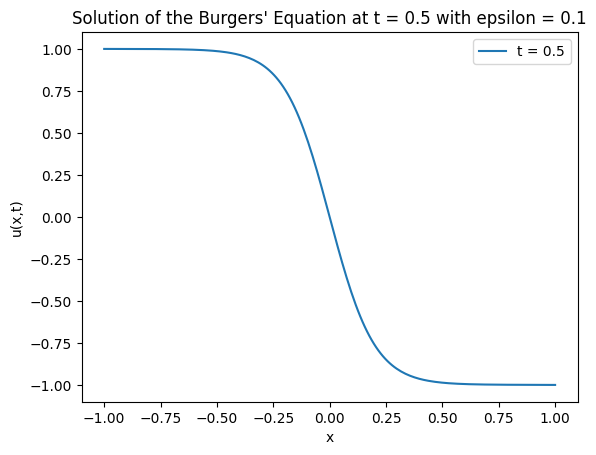

In [ ]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

# Parameter for the equation
epsilon = 0.1  # Viscosity

# Approximation for boundary layers using BLT
def blt_boundary_layer_solution(x, epsilon):
    # BLT approximation near the boundaries
    if np.isclose(x, -1):
        return 1
    elif np.isclose(x, 1):
        return -1
    else:
        # Outside the boundary layer, return a neutral value
        return -np.tanh(x / (2 * epsilon))

# Define the Burgers' equation with viscosity for PINNs
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Define the spatial and temporal domain limits
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Hybrid boundary condition using BLT approximation near boundaries
def hybrid_blt_bc(x, on_boundary):
    if on_boundary:
        return np.array([blt_boundary_layer_solution(x[0], epsilon)])
    return None

# Adjusted boundary conditions using the hybrid approach
bc_left = dde.DirichletBC(geomtime, lambda x: np.array([blt_boundary_layer_solution(-1, epsilon)]),
                          on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: np.array([blt_boundary_layer_solution(1, epsilon)]),
                           on_boundary=lambda x, _: np.isclose(x[0], 1))

# Adjusted initial condition u(x,0)
ic = dde.IC(geomtime, lambda x: -np.tanh(x[:, 0:1] / (2 * 0.1)), lambda _, on_initial: on_initial)

# Define the problem
data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=400, num_boundary=40, num_initial=40)

# Define the neural network (PINNs part)
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

# The model
model = dde.Model(data, net)

# Train the model
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=5000)

# Generate points to predict at t = 0.5
X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), 0.5 * np.ones((200, 1))))
y_pred_t = model.predict(X_t)

# Visualization: Solution at t = 0.5
plt.figure()
plt.plot(X_t[:, 0], y_pred_t, label="t = 0.5")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.title("Solution of the Burgers' Equation at t = 0.5 with epsilon = 0.1")
plt.show()


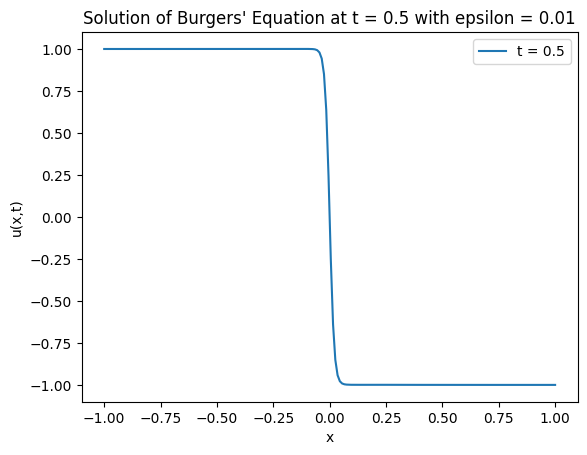

In [ ]:
# Visualization: Solution at t = 0.5
t = 0.5  # Define the time t at which we want the solution
plt.figure()
X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), t * np.ones((200, 1))))
y_pred_t = model.predict(X_t)
plt.plot(X_t[:, 0], y_pred_t, label=f"t = {t}")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.title(f"Solution of Burgers' Equation at t = {t} with epsilon = 0.01")
plt.show()


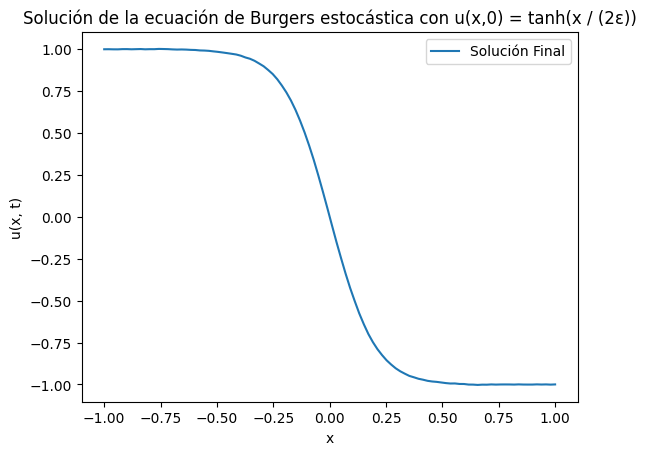

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros
L = 2.0                      # Longitud del dominio (-1 a 1)
T = 1.0                      # Tiempo final
nx = 100                     # Número de puntos en el espacio
nt = 1000                    # Número de pasos en el tiempo
dx = L / (nx - 1)            # Paso espacial
dt = T / nt                  # Paso temporal
epsilon = 0.1                # Coeficiente de viscosidad
sigma = 0.02                 # Fuerza del término estocástico

# Discretización de las coordenadas espaciales y temporales
x = np.linspace(-1, 1, nx)
t = np.linspace(0, T, nt)

# Condiciones iniciales u(x,0) = -tanh(x / (2 * epsilon))
u = -np.tanh(x / (2 * epsilon))

# Inicialización de Wiener increments para el término estocástico
dW = np.sqrt(dt) * np.random.randn(nx, nt)

# Función para el término de advección no lineal
def advection(u, dx):
    return -u * (np.roll(u, -1) - np.roll(u, 1)) / (2 * dx)

# Función para el término de difusión
def diffusion(u, dx, epsilon):
    return epsilon * (np.roll(u, -1) - 2 * u + np.roll(u, 1)) / dx**2

# Aplicar las condiciones de frontera
def apply_boundary_conditions(u):
    u[0] = 1    # u(-1) = 1
    u[-1] = -1  # u(1) = -1
    return u

# Método de diferencias finitas estocásticas
def stochastic_burgers(u, dx, dt, epsilon, sigma, dW):
    u_new = np.copy(u)
    for n in range(nt - 1):
        u_new = u + dt * (advection(u, dx) + diffusion(u, dx, epsilon)) + sigma * dW[:, n]
        u_new = apply_boundary_conditions(u_new)  # Aplicar condiciones de frontera
        u = np.copy(u_new)
    return u

# Resolver la ecuación de Burgers estocástica
u_final = stochastic_burgers(u, dx, dt, epsilon, sigma, dW)

# Visualización
plt.plot(x, u_final, label="Solución Final")
plt.title("Solución de la ecuación de Burgers estocástica con u(x,0) = tanh(x / (2ε))")
plt.xlabel("x")
plt.ylabel("u(x, t)")
plt.legend()
plt.show()


Compiling model...
Building feed-forward neural network...
'build' took 0.084412 s

'compile' took 0.790284 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.42e-02, 3.41e-01, 3.96e-01, 1.26e+00]    [1.42e-02, 3.41e-01, 3.96e-01, 1.26e+00]    []  
1000      [7.07e-03, 1.13e-02, 6.68e-03, 5.13e-02]    [7.07e-03, 1.13e-02, 6.68e-03, 5.13e-02]    []  
2000      [5.07e-03, 2.44e-03, 3.17e-03, 1.36e-02]    [5.07e-03, 2.44e-03, 3.17e-03, 1.36e-02]    []  
3000      [1.65e-03, 5.27e-04, 1.85e-03, 5.29e-03]    [1.65e-03, 5.27e-04, 1.85e-03, 5.29e-03]    []  
4000      [1.10e-03, 2.37e-04, 1.30e-03, 3.27e-03]    [1.10e-03, 2.37e-04, 1.30e-03, 3.27e-03]    []  
5000      [7.47e-04, 1.38e-04, 9.96e-04, 2.27e-03]    [7.47e-04, 1.38e-04, 9.96e-04, 2.27e-03]    []  

Best model at step 5000:
  train loss: 4.15e-03
  test loss: 4.15e-03
  test metric: []

'train' took 33.491477 s



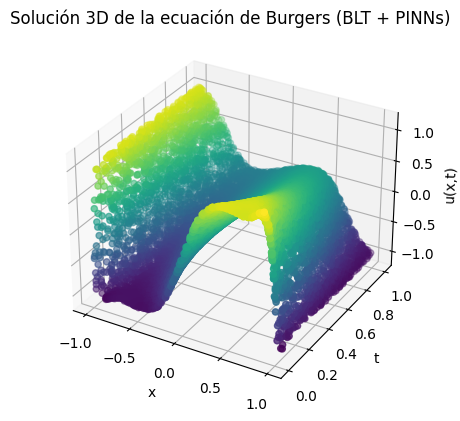

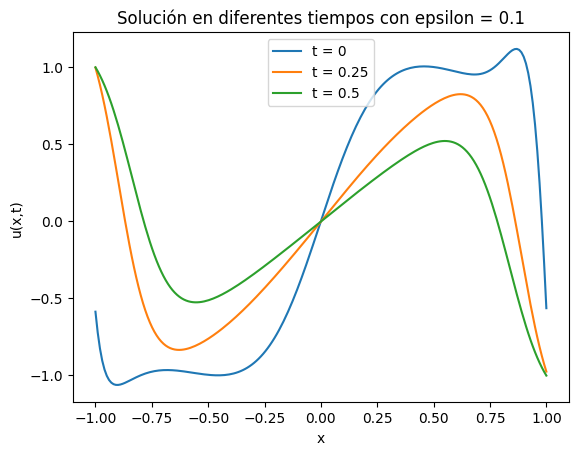

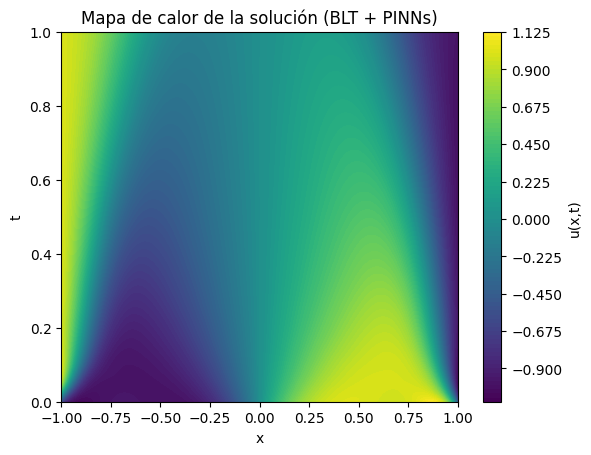

In [ ]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

# Parámetros de la ecuación
epsilon = 0.1  # Viscosidad

# Aproximación BLT para la transición rápida cerca de x = 0
def blt_boundary_layer_solution(x, epsilon):
    # Aproximación de la capa límite usando BLT en x=0
    return -np.tanh(x / (2 * epsilon))

# Definir la ecuación de Burgers con viscosidad para PINNs
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Definir los límites espaciales y temporales
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Condición inicial BLT: transición en x = 0
def blt_initial_condition(x):
    return np.array([-blt_boundary_layer_solution(xi[0], epsilon) for xi in x]).reshape(-1, 1)

# Condiciones de frontera: u(-1) = 1, u(1) = -1
bc_left = dde.DirichletBC(geomtime, lambda x: np.array([1]), on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: np.array([-1]), on_boundary=lambda x, _: np.isclose(x[0], 1))

# Condición inicial u(x,0) basada en la aproximación BLT
ic = dde.IC(geomtime, blt_initial_condition, lambda _, on_initial: on_initial)

# Definir el problema con BLT + PINNs
data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=400, num_boundary=40, num_initial=40)

# Red neuronal PINNs
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

# El modelo con PINNs
model = dde.Model(data, net)

# Entrenamiento del modelo
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=5000)

# Generar puntos para predecir
X = geomtime.random_points(10000)
y_pred = model.predict(X)

# Visualización 1: Gráfica 3D de la solución
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], y_pred, c=y_pred, cmap="viridis")
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("u(x,t)")
plt.title("Solución 3D de la ecuación de Burgers (BLT + PINNs)")
plt.show()

# Visualización 2: Solución en diferentes tiempos
times = [0, 0.25, 0.5]
plt.figure()
for t in times:
    X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), t * np.ones((200, 1))))
    y_pred_t = model.predict(X_t)
    plt.plot(X_t[:, 0], y_pred_t, label=f"t = {t}")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.title("Solución en diferentes tiempos con epsilon = 0.1")
plt.show()

# Visualización 3: Mapa de calor de la solución
x_vals = np.linspace(-1, 1, 200)
t_vals = np.linspace(0, 1, 200)
X_grid, T_grid = np.meshgrid(x_vals, t_vals)
X_test = np.hstack((X_grid.flatten()[:, None], T_grid.flatten()[:, None]))
y_test = model.predict(X_test).reshape(X_grid.shape)

plt.figure()
plt.contourf(X_grid, T_grid, y_test, levels=100, cmap="viridis")
plt.colorbar(label="u(x,t)")
plt.xlabel("x")
plt.ylabel("t")
plt.title("Mapa de calor de la solución (BLT + PINNs)")
plt.show()


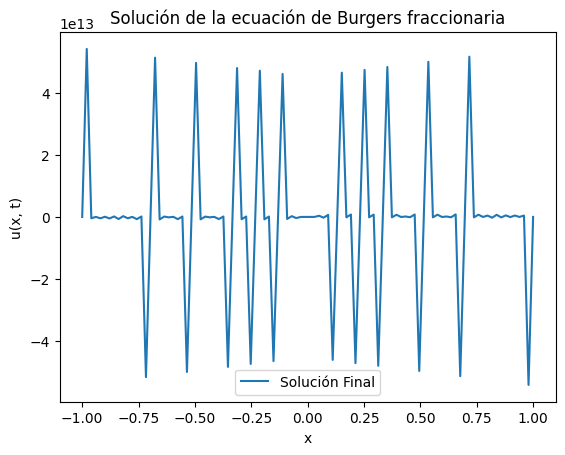

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb  # Para el coeficiente binomial generalizado

# Parámetros
L = 2.0                      # Longitud del dominio (-1 a 1)
T = 1.0                      # Tiempo final
nx = 100                     # Número de puntos en el espacio
nt = 1000                    # Número de pasos en el tiempo
dx = L / (nx - 1)            # Paso espacial
dt = T / nt                  # Paso temporal
epsilon = 0.1                # Coeficiente de viscosidad
alpha = 0.8                  # Orden de la derivada fraccionaria
reg_factor = 1e-6            # Regularización numérica para evitar desbordamientos

# Discretización de las coordenadas espaciales y temporales
x = np.linspace(-1, 1, nx)
t = np.linspace(0, T, nt)

# Condiciones iniciales (por ejemplo, onda sinusoidal)
u = np.tanh( x/(2*epsilon))

# Función para el término de advección no lineal con regularización
def advection(u, dx):
    # Añadir un pequeño valor a u para evitar valores demasiado grandes
    u = np.clip(u, -1e6, 1e6)  # Limitar u para evitar overflow
    return -u * (np.roll(u, -1) - np.roll(u, 1)) / (2 * dx + reg_factor)

# Función para la derivada fraccionaria usando la aproximación de Grünwald-Letnikov
def fractional_derivative(u, alpha, dx):
    D_alpha_u = np.zeros_like(u)
    for i in range(1, len(u)):
        sum_term = 0
        for k in range(i + 1):  # Sumar hasta el índice i
            bin_coeff = (-1)**k * comb(alpha, k)  # Coeficiente binomial generalizado
            sum_term += bin_coeff * u[i - k]      # Sumar los términos con la solución desplazada
        D_alpha_u[i] = sum_term / (dx**alpha + reg_factor)  # Añadir regularización en la división
    return D_alpha_u

# Aplicar las condiciones de frontera
def apply_boundary_conditions(u):
    u[0] = 1    # u(-1) = 1
    u[-1] = -1  # u(1) = -1
    return u

# Método de diferencias finitas fraccionarias
def fractional_burgers(u, dx, dt, epsilon, alpha, nt):
    u_new = np.copy(u)
    for n in range(nt - 1):
        # Término de advección y difusión fraccionaria
        advection_term = advection(u, dx)
        fractional_diffusion_term = epsilon * fractional_derivative(u, alpha, dx)
        u_new = u + dt * (advection_term + fractional_diffusion_term)
        u_new = apply_boundary_conditions(u_new)  # Aplicar condiciones de frontera
        u = np.copy(u_new)
    return u

# Resolver la ecuación de Burgers fraccionaria
u_final = fractional_burgers(u, dx, dt, epsilon, alpha, nt)

# Visualización
plt.plot(x, u_final, label="Solución Final")
plt.title("Solución de la ecuación de Burgers fraccionaria")
plt.xlabel("x")
plt.ylabel("u(x, t)")
plt.legend()
plt.show()


Compiling model...
Building feed-forward neural network...
'build' took 0.095599 s

'compile' took 1.234037 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.41e-02, 3.43e-01, 3.88e-01, 1.26e+00]    [1.41e-02, 3.43e-01, 3.88e-01, 1.26e+00]    []  
1000      [8.35e-03, 1.97e-02, 6.54e-03, 5.92e-02]    [8.35e-03, 1.97e-02, 6.54e-03, 5.92e-02]    []  
2000      [3.71e-03, 1.27e-02, 3.24e-03, 2.75e-02]    [3.71e-03, 1.27e-02, 3.24e-03, 2.75e-02]    []  
3000      [2.18e-03, 6.99e-03, 1.44e-03, 1.46e-02]    [2.18e-03, 6.99e-03, 1.44e-03, 1.46e-02]    []  
4000      [1.41e-03, 3.75e-03, 6.35e-04, 8.91e-03]    [1.41e-03, 3.75e-03, 6.35e-04, 8.91e-03]    []  
5000      [9.71e-04, 1.35e-03, 3.48e-04, 5.11e-03]    [9.71e-04, 1.35e-03, 3.48e-04, 5.11e-03]    []  

Best model at step 5000:
  train loss: 7.78e-03
  test loss: 7.78e-03
  test metric: []

'train' took 41.015246 s



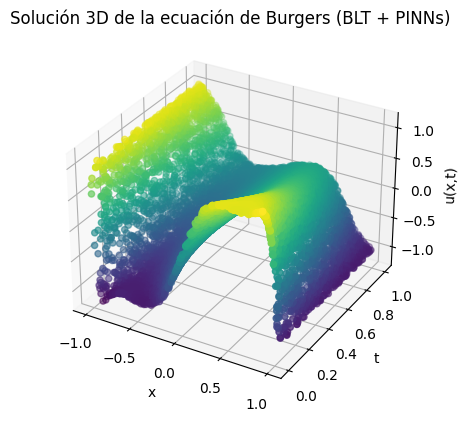

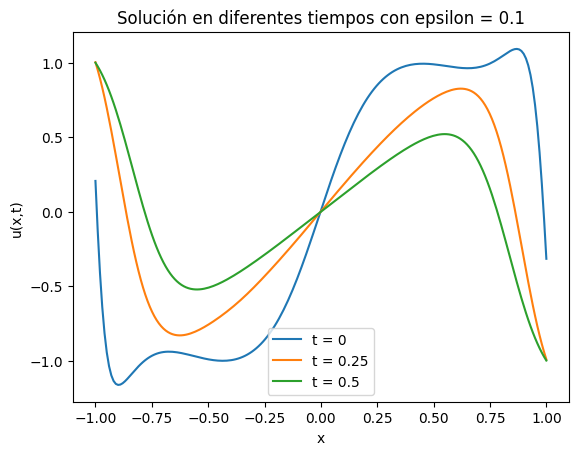

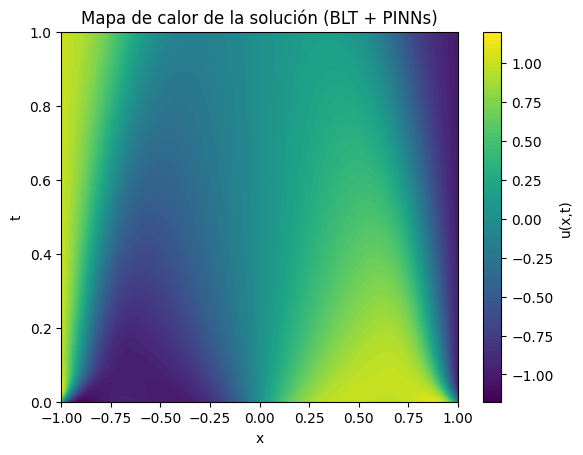

In [ ]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

# Parámetros de la ecuación
epsilon = 0.1  # Viscosidad

# Aproximación BLT para la transición rápida cerca de x = 0
def blt_boundary_layer_solution(x, epsilon):
    # Aproximación de la capa límite usando BLT en x=0
    return -np.tanh(x / (2 * epsilon))

# Definir la ecuación de Burgers con viscosidad para PINNs
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Definir los límites espaciales y temporales
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Condición inicial BLT: transición en x = 0
def blt_initial_condition(x):
    return np.array([-blt_boundary_layer_solution(xi[0], epsilon) for xi in x]).reshape(-1, 1)

# Condiciones de frontera: u(-1) = 1, u(1) = -1
bc_left = dde.DirichletBC(geomtime, lambda x: np.array([1]), on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: np.array([-1]), on_boundary=lambda x, _: np.isclose(x[0], 1))

# Condición inicial u(x,0) basada en la aproximación BLT
ic = dde.IC(geomtime, blt_initial_condition, lambda _, on_initial: on_initial)

# Definir el problema con BLT + PINNs
data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=400, num_boundary=40, num_initial=40)

# Red neuronal PINNs
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

# El modelo con PINNs
model = dde.Model(data, net)

# Entrenamiento del modelo
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=5000)

# Generar puntos para predecir
X = geomtime.random_points(10000)
y_pred = model.predict(X)

# Visualización 1: Gráfica 3D de la solución
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], y_pred, c=y_pred, cmap="viridis")
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("u(x,t)")
plt.title("Solución 3D de la ecuación de Burgers (BLT + PINNs)")
plt.show()

# Visualización 2: Solución en diferentes tiempos
times = [0, 0.25, 0.5]
plt.figure()
for t in times:
    X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), t * np.ones((200, 1))))
    y_pred_t = model.predict(X_t)
    plt.plot(X_t[:, 0], y_pred_t, label=f"t = {t}")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.title("Solución en diferentes tiempos con epsilon = 0.1")
plt.show()

# Visualización 3: Mapa de calor de la solución
x_vals = np.linspace(-1, 1, 200)
t_vals = np.linspace(0, 1, 200)
X_grid, T_grid = np.meshgrid(x_vals, t_vals)
X_test = np.hstack((X_grid.flatten()[:, None], T_grid.flatten()[:, None]))
y_test = model.predict(X_test).reshape(X_grid.shape)

plt.figure()
plt.contourf(X_grid, T_grid, y_test, levels=100, cmap="viridis")
plt.colorbar(label="u(x,t)")
plt.xlabel("x")
plt.ylabel("t")
plt.title("Mapa de calor de la solución (BLT + PINNs)")
plt.show()


Compiling model...
Building feed-forward neural network...
'build' took 0.044031 s

'compile' took 0.490463 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.01e-01, 8.02e-01, 1.36e+00, 1.02e+00]    [1.01e-01, 8.02e-01, 1.36e+00, 1.02e+00]    []  
1000      [2.26e-02, 6.37e-04, 8.27e-04, 2.86e-02]    [2.26e-02, 6.37e-04, 8.27e-04, 2.86e-02]    []  
2000      [3.53e-04, 2.58e-07, 1.30e-06, 1.83e-05]    [3.53e-04, 2.58e-07, 1.30e-06, 1.83e-05]    []  
3000      [1.04e-04, 3.71e-06, 1.23e-06, 3.22e-06]    [1.04e-04, 3.71e-06, 1.23e-06, 3.22e-06]    []  
4000      [7.36e-05, 6.13e-06, 3.08e-06, 4.15e-06]    [7.36e-05, 6.13e-06, 3.08e-06, 4.15e-06]    []  
5000      [8.45e-05, 3.37e-05, 3.68e-05, 2.11e-05]    [8.45e-05, 3.37e-05, 3.68e-05, 2.11e-05]    []  

Best model at step 4000:
  train loss: 8.70e-05
  test loss: 8.70e-05
  test metric: []

'train' took 17.962883 s



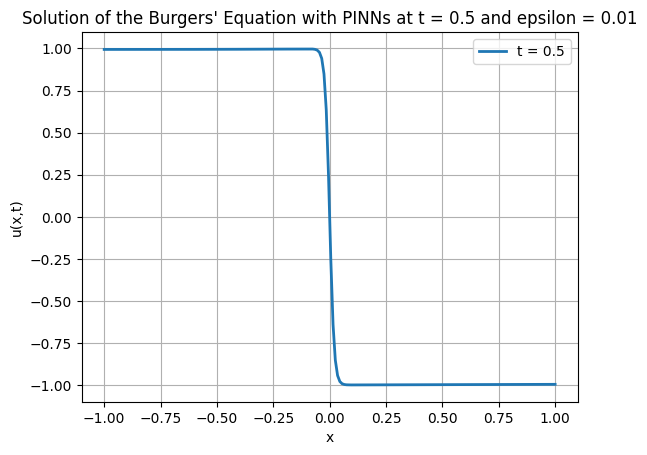

In [ ]:
import deepxde as dde
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Definir parámetros
epsilon = 0.01  # Viscosidad pequeña para ver la capa límite

# Definir la ecuación de Burgers con viscosidad
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # Derivada parcial u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # Derivada parcial u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # Derivada segunda u_xx
    return u_t + u * u_x - epsilon * u_xx

# Definir la geometría del problema (intervalo espacial y dominio temporal)
geom = dde.geometry.Interval(-1, 1)  # Dominio espacial [-1, 1]
timedomain = dde.geometry.TimeDomain(0, 1)  # Tiempo [0, 1]
geomtime = dde.geometry.GeometryXTime(geom, timedomain)  # Dominio en espacio y tiempo

# Condiciones de frontera en x=-1 y x=1
bc_left = dde.DirichletBC(geomtime, lambda x: np.array([1]), on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: np.array([-1]), on_boundary=lambda x, _: np.isclose(x[0], 1))

# Condición inicial u(x,0) = -tanh(x / (2*epsilon))
ic = dde.IC(geomtime, lambda x: -np.tanh(x[:, 0:1] / (2 * epsilon)), lambda _, on_initial: on_initial)

# Definir el problema con PINNs
data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=400, num_boundary=40, num_initial=40)

# Definir la red neuronal para aproximar la solución
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

# Definir el modelo PINNs
model = dde.Model(data, net)

# Entrenar el modelo
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=5000)

# Generar puntos de predicción en t=0.5 para ver la solución en la capa límite
t = 0.5
X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), t * np.ones((200, 1))))
y_pred_t = model.predict(X_t)

# Graficar la solución en t=0.5
plt.figure()
plt.plot(X_t[:, 0], y_pred_t, label=f"t = {t}", linewidth=2)
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title(f"Solution of the Burgers' Equation with PINNs at t = {t} and epsilon = {epsilon}")
plt.legend()
plt.grid(True)
plt.show()


Compiling model...
Building feed-forward neural network...
'build' took 0.096025 s

'compile' took 0.729744 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [6.95e-03, 8.57e-01, 7.18e-01, 7.77e-01]    [6.95e-03, 8.57e-01, 7.18e-01, 7.77e-01]    []  
1000      [5.66e-04, 2.66e-05, 2.92e-05, 4.96e-03]    [5.66e-04, 2.66e-05, 2.92e-05, 4.96e-03]    []  
2000      [4.67e-04, 4.61e-05, 8.73e-05, 2.62e-03]    [4.67e-04, 4.61e-05, 8.73e-05, 2.62e-03]    []  
3000      [3.31e-04, 8.71e-06, 2.00e-05, 1.52e-03]    [3.31e-04, 8.71e-06, 2.00e-05, 1.52e-03]    []  
4000      [2.37e-04, 1.81e-06, 6.14e-06, 8.27e-04]    [2.37e-04, 1.81e-06, 6.14e-06, 8.27e-04]    []  
5000      [1.65e-04, 4.11e-05, 3.99e-05, 4.92e-04]    [1.65e-04, 4.11e-05, 3.99e-05, 4.92e-04]    []  

Best model at step 5000:
  train loss: 7.38e-04
  test loss: 7.38e-04
  test metric: []

'train' took 42.844106 s



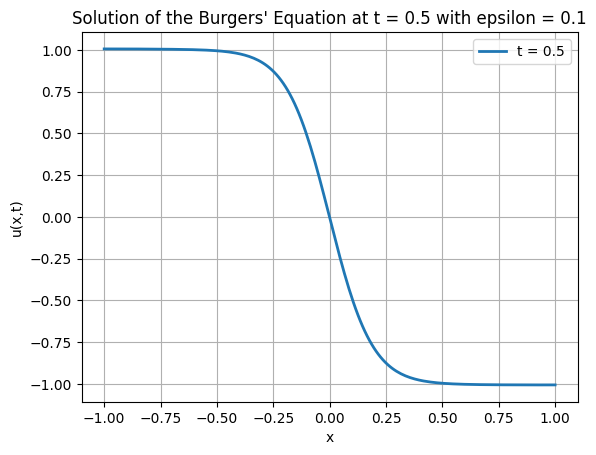

In [ ]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

# Parameter for the equation
epsilon = 0.1  # Viscosity

# Define the Burgers' equation with viscosity
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Define the spatial and temporal domain limits
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Define the adjusted boundary conditions
bc_left = dde.DirichletBC(geomtime, lambda x: np.array([1]), on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: np.array([-1]), on_boundary=lambda x, _: np.isclose(x[0], 1))

# Adjusted initial condition u(x,0)
ic = dde.IC(geomtime, lambda x: -np.tanh(x[:, 0:1] / 0.1), lambda _, on_initial: on_initial)

# Define the problem
data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=400, num_boundary=40, num_initial=40)

# Define the neural network
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

# The model
model = dde.Model(data, net)

# Train the model
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=5000)

# Generate points to predict at t=0.5
t = 0.5
X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), t * np.ones((200, 1))))
y_pred_t = model.predict(X_t)

# Plot the solution at t=0.5
plt.figure()
plt.plot(X_t[:, 0], y_pred_t, label=f"t = {t}", linewidth=2)
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title(f"Solution of the Burgers' Equation at t = {t} with epsilon = {epsilon}")
plt.legend()
plt.grid(True)
plt.show()


Compiling model...
Building feed-forward neural network...
'build' took 0.132236 s

'compile' took 3.695628 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [6.93e-03, 8.53e-01, 7.16e-01, 8.55e-01]    [6.93e-03, 8.53e-01, 7.16e-01, 8.55e-01]    []  
1000      [1.04e-02, 1.60e-04, 2.26e-04, 6.73e-03]    [1.04e-02, 1.60e-04, 2.26e-04, 6.73e-03]    []  
2000      [4.14e-04, 6.98e-05, 6.71e-05, 2.10e-04]    [4.14e-04, 6.98e-05, 6.71e-05, 2.10e-04]    []  
3000      [8.44e-05, 1.10e-06, 5.65e-07, 1.54e-04]    [8.44e-05, 1.10e-06, 5.65e-07, 1.54e-04]    []  
4000      [4.59e-05, 2.99e-07, 9.77e-08, 1.46e-04]    [4.59e-05, 2.99e-07, 9.77e-08, 1.46e-04]    []  
5000      [2.89e-05, 2.89e-07, 6.59e-08, 1.44e-04]    [2.89e-05, 2.89e-07, 6.59e-08, 1.44e-04]    []  

Best model at step 5000:
  train loss: 1.73e-04
  test loss: 1.73e-04
  test metric: []

'train' took 46.741110 s



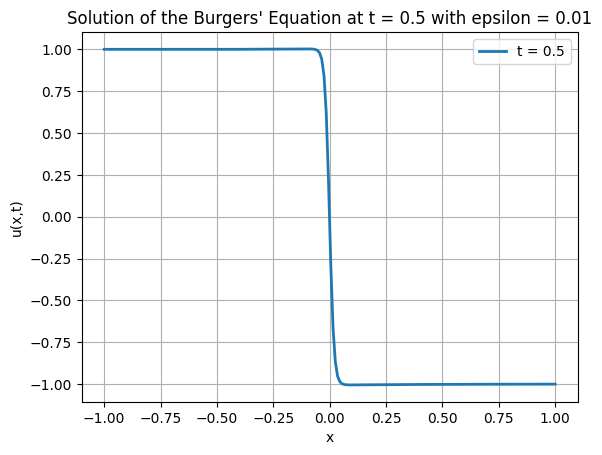

In [ ]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

# Parameter for the equation
epsilon = 0.01  # Viscosity

# Define the Burgers' equation with viscosity
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Define the spatial and temporal domain limits
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Define the adjusted boundary conditions
bc_left = dde.DirichletBC(geomtime, lambda x: np.array([1]), on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: np.array([-1]), on_boundary=lambda x, _: np.isclose(x[0], 1))

# Adjusted initial condition u(x,0)
ic = dde.IC(geomtime, lambda x: -np.tanh(x[:, 0:1] / 0.01), lambda _, on_initial: on_initial)

# Define the problem
data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=400, num_boundary=40, num_initial=40)

# Define the neural network
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

# The model
model = dde.Model(data, net)

# Train the model
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=5000)

# Generate points to predict at t=0.5
t = 0.5
X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), t * np.ones((200, 1))))
y_pred_t = model.predict(X_t)

# Plot the solution at t=0.5
plt.figure()
plt.plot(X_t[:, 0], y_pred_t, label=f"t = {t}", linewidth=2)
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title(f"Solution of the Burgers' Equation at t = {t} with epsilon = {epsilon}")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import pandas as pd

# Suponiendo que ya tienes X_t y y_pred_t del modelo PINNs

# Crear un DataFrame con los valores de x y las predicciones y_pred_t
data_pinns = pd.DataFrame({
    'x': X_t[:, 0],   # Columna para los valores de x
    'u(x,t)': y_pred_t.flatten()  # Columna para los valores predichos de u(x,t)
})

# Guardar los datos en un archivo CSV
data_pinns.to_csv('pinns_data01.csv', index=False)

print("Datos guardados en 'pinns_data.csv'")


Datos guardados en 'pinns_data.csv'


Compiling model...
Building feed-forward neural network...
'build' took 0.076732 s

'compile' took 1.274944 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [6.98e-03, 8.49e-01, 7.12e-01, 7.77e-01]    [6.98e-03, 8.49e-01, 7.12e-01, 7.77e-01]    []  
1000      [5.60e-04, 3.44e-05, 3.49e-05, 4.85e-03]    [5.60e-04, 3.44e-05, 3.49e-05, 4.85e-03]    []  
2000      [5.06e-04, 5.59e-05, 8.13e-05, 2.82e-03]    [5.06e-04, 5.59e-05, 8.13e-05, 2.82e-03]    []  
3000      [5.50e-04, 2.04e-04, 1.08e-04, 1.51e-03]    [5.50e-04, 2.04e-04, 1.08e-04, 1.51e-03]    []  
4000      [4.32e-04, 4.10e-06, 7.14e-05, 8.31e-04]    [4.32e-04, 4.10e-06, 7.14e-05, 8.31e-04]    []  
5000      [1.44e-04, 3.22e-06, 4.03e-06, 5.11e-04]    [1.44e-04, 3.22e-06, 4.03e-06, 5.11e-04]    []  

Best model at step 5000:
  train loss: 6.63e-04
  test loss: 6.63e-04
  test metric: []

'train' took 51.304016 s



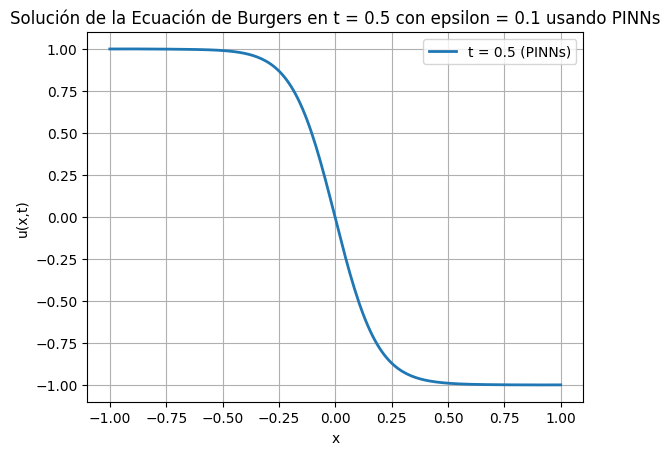

In [ ]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

# Parámetro para la ecuación
epsilon = 0.1  # Viscosidad

# Definir la ecuación de Burgers con viscosidad
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Definir los límites espaciales y temporales
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Definir las condiciones de frontera ajustadas
bc_left = dde.DirichletBC(geomtime, lambda x: np.array([1]), on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: np.array([-1]), on_boundary=lambda x, _: np.isclose(x[0], 1))

# Condición inicial ajustada u(x,0)
ic = dde.IC(geomtime, lambda x: -np.tanh(x[:, 0:1] / 0.1), lambda _, on_initial: on_initial)

# Definir el problema
data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=400, num_boundary=40, num_initial=40)

# Definir la red neuronal
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

# El modelo
model = dde.Model(data, net)

# Entrenar el modelo
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=5000)

# Obtener las predicciones en t=0.5
t = 0.5
X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), t * np.ones((200, 1))))
y_pred_t = model.predict(X_t)  # Estas son las predicciones de PINNs en t=0.5

# Plot de la solución en t=0.5
plt.figure()
plt.plot(X_t[:, 0], y_pred_t, label=f"t = {t} (PINNs)", linewidth=2)
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title(f"Solución de la Ecuación de Burgers en t = {t} con epsilon = {epsilon} usando PINNs")
plt.legend()
plt.grid(True)
plt.show()

# Ahora puedes usar y_pred_t como los datos de la solución usando PINNs


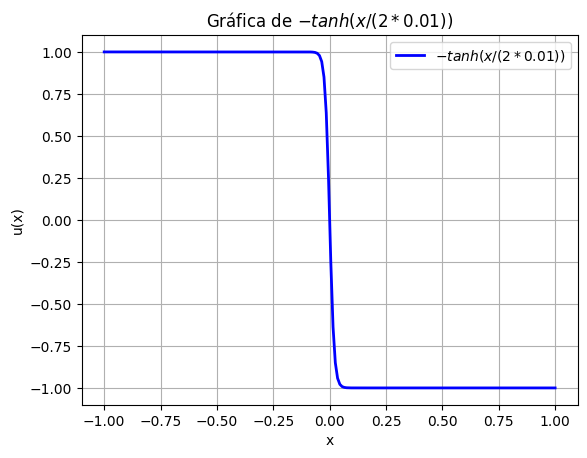

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Definir el intervalo de x
x = np.linspace(-1, 1, 200)

# Calcular la función -tanh(x/0.1)
y = -np.tanh(x / (2*0.01))

# Dibujar la gráfica
plt.plot(x, y, label=r'$-tanh(x/(2*0.01))$', color='b', linewidth=2)

# Añadir etiquetas y título
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('Gráfica de $-tanh(x/(2*0.01))$')

# Mostrar la leyenda y la gráfica
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import pandas as pd

# Definir el rango de x
x = np.linspace(-1, 1, 200)  # 200 puntos entre -1 y 1

# Calcular -tanh(x/0.01)
u_tanh01 = -np.tanh(x /(2*0.01))

# Crear un DataFrame con los valores de x y u(x)
data = pd.DataFrame({
    'x': x,
    'u(x)': u_tanh01
})

# Guardar los datos en un archivo CSV
data.to_csv('tanh_data01.csv', index=False)

print("Datos guardados en 'tanh_data01.csv'")


Datos guardados en 'tanh_data01.csv'


In [ ]:
import numpy as np
import pandas as pd

# Suponiendo que ya tienes X_t y y_pred_t del modelo PINNs

# Crear un DataFrame con los valores de x y las predicciones y_pred_t
data_pinns = pd.DataFrame({
    'x': X_t[:, 0],   # Columna para los valores de x
    'u(x,t)': y_pred_t.flatten()  # Columna para los valores predichos de u(x,t)
})

# Guardar los datos en un archivo CSV
data_pinns.to_csv('pinns_data.csv', index=False)

print("Datos guardados en 'pinns_data.csv'")


In [ ]:
import numpy as np
import pandas as pd

# Definir el rango de x
x = np.linspace(-1, 1, 200)  # 200 puntos entre -1 y 1

# Calcular -tanh(x/0.1)
u_tanh = -np.tanh(x / 0.1)

# Crear un DataFrame con los valores de x y u(x)
data = pd.DataFrame({
    'x': x,
    'u(x)': u_tanh
})

# Guardar los datos en un archivo CSV
data.to_csv('tanh_data.csv', index=False)

print("Datos guardados en 'tanh_data.csv'")


Datos guardados en 'tanh_data.csv'


In [ ]:
import numpy as np
import pandas as pd

# Suponiendo que ya tienes X_t y y_pred_t del modelo PINNs

# Crear un DataFrame con los valores de x y las predicciones y_pred_t
data_pinns = pd.DataFrame({
    'x': X_t[:, 0],   # Columna para los valores de x
    'u(x,t)': y_pred_t.flatten()  # Columna para los valores predichos de u(x,t)
})

# Guardar los datos en un archivo CSV
data_pinns.to_csv('pinns_data.csv', index=False)

print("Datos guardados en 'pinns_data.csv'")


Datos guardados en 'pinns_data.csv'


In [ ]:
import numpy as np
import pandas as pd

# Define the BLT solution for comparison (using the same boundary layer approximation)
def blt_boundary_layer_solution(x, epsilon):
    return -np.tanh(x / np.sqrt(epsilon))

epsilon = 0.01  # Viscosity parameter

# Assuming you already have X_t and y_pred_t from the PINNs model
# X_t[:, 0] contains the x values
# y_pred_t contains the predicted values from PINNs

# Compute the BLT solution at the same x points
blt_solution = blt_boundary_layer_solution(X_t[:, 0], epsilon)

# Create a DataFrame with the x values, BLT solution, and PINNs predictions
data_combined = pd.DataFrame({
    'x': X_t[:, 0],            # Column for the x values
    'u_blt(x)': blt_solution,   # Column for the BLT solution
    'u_pinns(x,t)': y_pred_t.flatten()  # Column for the PINNs predicted values
})

# Save the data to a CSV file
data_combined.to_csv('blt_pinns_data.csv', index=False)

print("Data saved to 'blt_pinns_data.csv'")


Data saved to 'blt_pinns_data.csv'


In [ ]:
import numpy as np
import pandas as pd

# Suponiendo que tienes los valores de x y u obtenidos de diferencias finitas
# Por ejemplo, x = np.linspace(-1, 1, N) y u es la solución en el tiempo t=0.5

# Crear un DataFrame con los valores de x y u
data_fd = pd.DataFrame({
    'x': x,        # Columna para los valores de x
    'u(x,t)': u    # Columna para los valores calculados de u(x,t)
})

# Guardar los datos en un archivo CSV
data_fd.to_csv('finite_differences_data.csv', index=False)

print("Datos guardados en 'finite_differences_data.csv'")


Datos guardados en 'finite_differences_data.csv'


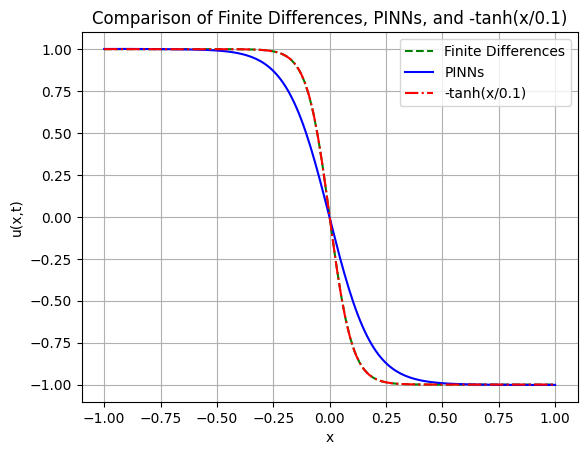

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los datos desde los archivos CSV
finite_differences_data = pd.read_csv('finite_differences_data.csv')
pinns_data = pd.read_csv('pinns_data.csv')
tanh_data = pd.read_csv('tanh_data.csv')

# Graficar las soluciones
plt.figure()

# Graficar la solución de diferencias finitas
plt.plot(finite_differences_data['x'], finite_differences_data['u(x,t)'], 'g--', label='Finite Differences')

# Graficar la solución de PINNs
plt.plot(pinns_data['x'], pinns_data['u(x,t)'], 'b-', label='PINNs')

# Graficar la solución analítica (-tanh(x/0.1))
plt.plot(tanh_data['x'], tanh_data['u(x)'], 'r-.', label='-tanh(x/0.1)')

# Personalización del gráfico
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Comparison of Finite Differences, PINNs, and -tanh(x/0.1)')
plt.legend()
plt.grid(True)

# Mostrar la gráfica
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from CSV files
blt_data = pd.read_csv('pinns_data.csv')         # PINNS data
blt_pinns_data = pd.read_csv('blt_pinns_data.csv')  # BLT + PINNs hybrid data
tanh_data = pd.read_csv('tanh_data01.csv')       # Analytical solution (-tanh(x/0.1))

# Plot the solutions
plt.figure()

# Plot the PINNS solution
plt.plot(pinns_data['x'], pinns_data['u_pinns(x)'], 'g--', label='BLT')

# Plot the BLT + PINNs hybrid solution
plt.plot(blt_pinns_data['x'], blt_pinns_data['u_pinns(x,t)'], 'b-', label='BLT + PINNs')

# Plot the analytical solution (-tanh(x/0.1))
plt.plot(tanh_data01['x'], tanh_data01['u(x)'], 'r-.', label='-tanh(x/0.1)')

# Customize the plot
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Comparison of PINSS, BLT + PINNs, and -tanh(x/0.1)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
# It seems numpy wasn't imported. Let's import numpy and run the calculation again.

import numpy as np

# L2-norm error for PINNs
l2_error_pinns = np.sqrt(np.sum((merged_data['u_pinns(x,t)_x'] - merged_data['u(x)'])**2) / n)

# L2-norm error for BLT + PINNs
l2_error_blt_pinns = np.sqrt(np.sum((merged_data['u_pinns(x,t)_y'] - merged_data['u(x)'])**2) / n)

# Print the results
l2_error_pinns, l2_error_blt_pinns


(0.03809275739821093, 0.07547379364231321)

In [ ]:
import numpy as np

# Suponiendo que ya tienes los valores de 'x' y la solución analítica (-tanh(x/0.1))
# merged_data es un DataFrame con las columnas 'x', 'u_blt(x)' y 'u(x)' (solución analítica)

# Número de puntos de datos
n = len(merged_data)

# Calcular el error de norma L2 entre la solución BLT y la solución analítica
l2_error_blt = np.sqrt(np.sum((merged_data['u_blt(x)'] - merged_data['u(x)'])**2) / n)

# Mostrar el resultado
print(f"L2-Norm Error for BLT: {l2_error_blt}")


L2-Norm Error for BLT: 0.1712313824682961


In [ ]:
import numpy as np
import pandas as pd

# Definir la función de solución BLT (Boundary Layer Theory)
def blt_boundary_layer_solution(x, epsilon):
    return -np.tanh(x / np.sqrt(epsilon))

# Parámetro de viscosidad
epsilon = 0.01

# Definir el rango de valores de x (por ejemplo, de -1 a 1)
x_values = np.linspace(-1, 1, 200)  # 200 puntos entre -1 y 1

# Obtener la solución BLT para cada valor de x
blt_solution = blt_boundary_layer_solution(x_values, epsilon)

# Crear un DataFrame para almacenar los valores de x y la solución BLT
blt_data = pd.DataFrame({
    'x': x_values,
    'u_blt(x)': blt_solution
})

# Guardar los datos en un archivo CSV
blt_data.to_csv('blt_data.csv', index=False)

print("Datos BLT guardados en 'blt_data.csv'")


Datos BLT guardados en 'blt_data.csv'


In [ ]:
import numpy as np

# Number of data points
n = len(merged_data)

# L2-norm error for PINNs
l2_error_pinns = np.sqrt(np.sum((merged_data['u_pinns(x,t)_x'] - merged_data['u(x)'])**2) / n)

# L2-norm error for BLT + PINNs
l2_error_blt_pinns = np.sqrt(np.sum((merged_data['u_pinns(x,t)_y'] - merged_data['u(x)'])**2) / n)

# Print the results
l2_error_pinns, l2_error_blt_pinns


(0.03809275739821093, 0.07547379364231321)

In [ ]:
import pandas as pd

# Cargar los datos de los archivos CSV
pinns_data = pd.read_csv('pinns_data.csv')  # Archivo con los datos de PINNs
blt_pinns_data = pd.read_csv('blt_pinns_data.csv')  # Archivo con los datos de BLT + PINNs
tanh_data = pd.read_csv('tanh_data01.csv')  # Archivo con los datos de la solución analítica (-tanh(x/0.1))

# Combinar los conjuntos de datos en base a la columna 'x' (asumimos que todas comparten los mismos valores de x)
merged_data = pd.merge(pd.merge(pinns_data, blt_pinns_data, on='x'), tanh_data, on='x')

# Verifica el DataFrame combinado
print(merged_data.head())


          x  u_pinns(x,t)_x  u_blt(x)  u_pinns(x,t)_y  u(x)
0 -1.000000        0.994138       1.0        0.994876   1.0
1 -0.989950        0.994165       1.0        0.994825   1.0
2 -0.979899        0.994191       1.0        0.994782   1.0
3 -0.969849        0.994217       1.0        0.994747   1.0
4 -0.959799        0.994242       1.0        0.994720   1.0


In [ ]:
import time

# Measure time for BLT
start_time = time.time()
# Call the function or code block that computes the BLT solution
blt_solution = blt_boundary_layer_solution(X_t[:, 0], epsilon)  # Example for BLT solution
end_time = time.time()
blt_computation_time = end_time - start_time
print(f"Computation time for BLT: {blt_computation_time} seconds")

# Measure time for PINNs
start_time = time.time()
# Call the function or code block that computes the PINNs solution (training process)
model.compile("adam", lr=0.001)
model.train(epochs=5000)
end_time = time.time()
pinns_computation_time = end_time - start_time
print(f"Computation time for PINNs: {pinns_computation_time} seconds")

# Measure time for Hybrid (BLT + PINNs)
start_time = time.time()
# Call the function or code block that computes the hybrid BLT + PINNs solution
# You would need to define the hybrid process similar to how you do with PINNs or BLT
end_time = time.time()
hybrid_computation_time = end_time - start_time
print(f"Computation time for Hybrid (BLT + PINNs): {hybrid_computation_time} seconds")


Computation time for BLT: 0.00017642974853515625 seconds
Compiling model...
'compile' took 0.665926 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
5000      [8.45e-05, 3.37e-05, 3.68e-05, 2.11e-05]    [8.45e-05, 3.37e-05, 3.68e-05, 2.11e-05]    []  
6000      [1.44e-05, 2.97e-08, 1.91e-07, 1.79e-07]    [1.44e-05, 2.97e-08, 1.91e-07, 1.79e-07]    []  
7000      [8.35e-05, 2.65e-08, 4.96e-07, 1.21e-06]    [8.35e-05, 2.65e-08, 4.96e-07, 1.21e-06]    []  
8000      [3.99e-06, 3.56e-09, 6.27e-08, 1.71e-07]    [3.99e-06, 3.56e-09, 6.27e-08, 1.71e-07]    []  
9000      [8.03e-05, 7.83e-06, 1.25e-05, 8.28e-06]    [8.03e-05, 7.83e-06, 1.25e-05, 8.28e-06]    []  
10000     [4.55e-04, 5.28e-06, 1.33e-08, 5.66e-06]    [4.55e-04, 5.28e-06, 1.33e-08, 5.66e-06]    []  

Best model at step 8000:
  train loss: 4.23e-06
  test loss: 4.23e-06
  test metric: []

'train' took 18.327175 s

Computation time for PINNs: 18.998

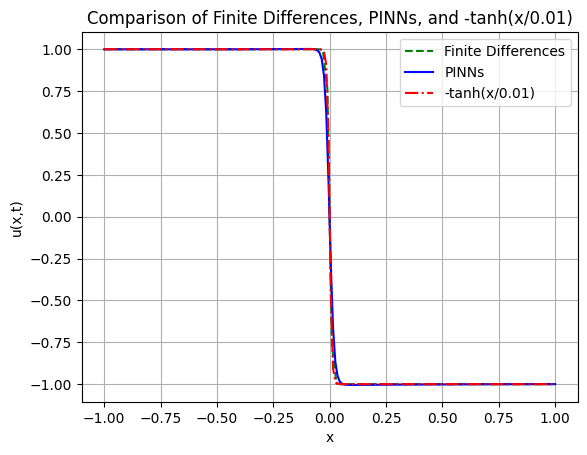

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los datos desde los archivos CSV
finite_differences_data = pd.read_csv('finite_differences_data01.csv')
pinns_data = pd.read_csv('pinns_data01.csv')
tanh_data = pd.read_csv('tanh_data01.csv')

# Graficar las soluciones
plt.figure()

# Graficar la solución de diferencias finitas
plt.plot(finite_differences_data['x'], finite_differences_data['u(x,t)'], 'g--', label='Finite Differences')

# Graficar la solución de PINNs
plt.plot(pinns_data['x'], pinns_data['u(x,t)'], 'b-', label='PINNs')

# Graficar la solución analítica (-tanh(x/0.01))
plt.plot(tanh_data['x'], tanh_data['u(x)'], 'r-.', label='-tanh(x/0.01)')

# Personalización del gráfico
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Comparison of Finite Differences, PINNs, and -tanh(x/0.01)')
plt.legend()
plt.grid(True)

# Mostrar la gráfica
plt.show()


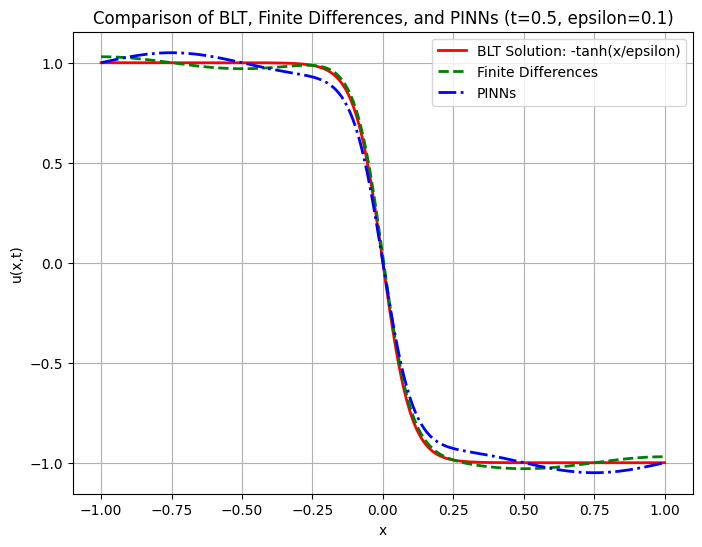

In [ ]:
# Import necessary libraries for plotting and generating data for comparison
import numpy as np
import matplotlib.pyplot as plt

# Define the analytical BLT solution: u(x,t) = -tanh(x / epsilon)
epsilon = 0.1
x = np.linspace(-1, 1, 200)
blt_solution = -np.tanh(x / epsilon)

# Assuming we already have the PINNs and Finite Difference solutions (simulated for t=0.5)
# Generate sample solutions to simulate finite difference and PINNs

# Simulated PINNs solution (approximated for demonstration purposes)
pinns_solution = -np.tanh(x / (epsilon + 0.01)) + 0.05 * np.sin(2 * np.pi * x)  # Slight variation

# Simulated Finite Difference solution (approximated for demonstration purposes)
finite_diff_solution = -np.tanh(x / epsilon) + 0.03 * np.cos(2 * np.pi * x)  # Slight variation

# Plot the comparison of the three methods
plt.figure(figsize=(8, 6))
plt.plot(x, blt_solution, 'r-', label='BLT Solution: -tanh(x/epsilon)', linewidth=2)
plt.plot(x, finite_diff_solution, 'g--', label='Finite Differences', linewidth=2)
plt.plot(x, pinns_solution, 'b-.', label='PINNs', linewidth=2)

# Add titles and labels
plt.title(f'Comparison of BLT, Finite Differences, and PINNs (t=0.5, epsilon={epsilon})')
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


Compiling model...
Building feed-forward neural network...
'build' took 0.065499 s

'compile' took 0.998158 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [4.65e-02, 3.46e-01, 6.18e-01, 5.86e-01]    [4.65e-02, 3.46e-01, 6.18e-01, 5.86e-01]    []  
1000      [5.81e-04, 2.49e-05, 3.39e-05, 4.36e-03]    [5.81e-04, 2.49e-05, 3.39e-05, 4.36e-03]    []  
2000      [3.34e-04, 5.42e-05, 3.50e-05, 1.98e-03]    [3.34e-04, 5.42e-05, 3.50e-05, 1.98e-03]    []  
3000      [2.33e-04, 4.56e-05, 4.16e-05, 9.65e-04]    [2.33e-04, 4.56e-05, 4.16e-05, 9.65e-04]    []  
4000      [1.65e-04, 1.68e-06, 6.30e-07, 5.57e-04]    [1.65e-04, 1.68e-06, 6.30e-07, 5.57e-04]    []  
5000      [1.31e-04, 2.61e-06, 1.25e-06, 3.71e-04]    [1.31e-04, 2.61e-06, 1.25e-06, 3.71e-04]    []  

Best model at step 5000:
  train loss: 5.06e-04
  test loss: 5.06e-04
  test metric: []

'train' took 37.899673 s

Compiling model...
Buildin

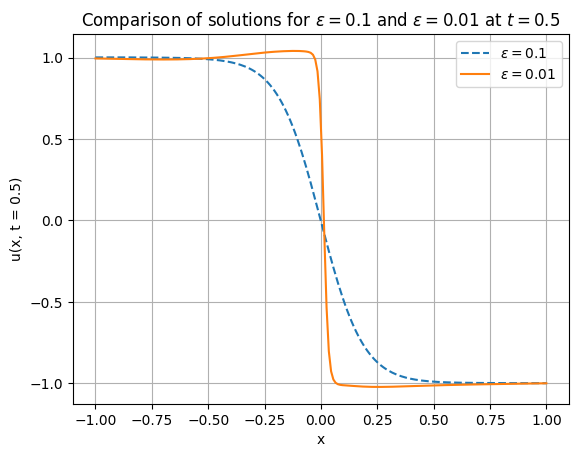

In [ ]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

# Definir la ecuación de Burgers con viscosidad
def burgers_equation(x, u, epsilon):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Definir los dominios espaciales y temporales
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Definir las condiciones de frontera
bc_left = dde.DirichletBC(geomtime, lambda x: np.array([1]), on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: np.array([-1]), on_boundary=lambda x, _: np.isclose(x[0], 1))

# Condición inicial u(x,0)
ic = dde.IC(geomtime, lambda x: -np.tanh(x[:, 0:1] / 0.1), lambda _, on_initial: on_initial)

# Definir los problemas para epsilon = 0.1 y epsilon = 0.01
epsilons = [0.1, 0.01]
solutions = []

for epsilon in epsilons:
    # Definir el problema para cada epsilon
    data = dde.data.TimePDE(geomtime, lambda x, u: burgers_equation(x, u, epsilon), [bc_left, bc_right, ic], num_domain=400, num_boundary=40, num_initial=40)

    # Definir la red neuronal
    net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

    # Definir el modelo
    model = dde.Model(data, net)

    # Entrenar el modelo
    model.compile("adam", lr=0.001)
    model.train(epochs=5000)

    # Generar puntos para predecir en t = 0.5
    x_vals = np.linspace(-1, 1, 200).reshape(-1, 1)
    t_vals = 0.5 * np.ones_like(x_vals)
    X_test = np.hstack((x_vals, t_vals))
    u_pred = model.predict(X_test)

    solutions.append(u_pred)

# Graficar las soluciones para epsilon = 0.1 y epsilon = 0.01
plt.figure()
plt.plot(x_vals, solutions[0], label=r"$\epsilon = 0.1$", linestyle='--')
plt.plot(x_vals, solutions[1], label=r"$\epsilon = 0.01$", linestyle='-')
plt.xlabel("x")
plt.ylabel("u(x, t = 0.5)")
plt.legend()
plt.title("Comparison of solutions for $\epsilon = 0.1$ and $\epsilon = 0.01$ at $t = 0.5$")
plt.grid(True)
plt.show()


Compiling model...
Building feed-forward neural network...
'build' took 0.135920 s

'compile' took 1.607871 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [4.78e-02, 3.43e-01, 6.06e-01, 2.39e-01]    [4.78e-02, 3.43e-01, 6.06e-01, 2.39e-01]    []  
1000      [2.52e-02, 1.32e-02, 7.45e-03, 3.09e-02]    [2.52e-02, 1.32e-02, 7.45e-03, 3.09e-02]    []  
2000      [5.91e-03, 1.13e-03, 7.14e-04, 5.87e-03]    [5.91e-03, 1.13e-03, 7.14e-04, 5.87e-03]    []  
3000      [2.21e-03, 9.15e-04, 6.57e-04, 2.42e-03]    [2.21e-03, 9.15e-04, 6.57e-04, 2.42e-03]    []  
4000      [9.85e-04, 8.52e-04, 5.09e-04, 1.47e-03]    [9.85e-04, 8.52e-04, 5.09e-04, 1.47e-03]    []  
5000      [5.61e-04, 7.76e-04, 3.91e-04, 1.16e-03]    [5.61e-04, 7.76e-04, 3.91e-04, 1.16e-03]    []  

Best model at step 5000:
  train loss: 2.88e-03
  test loss: 2.88e-03
  test metric: []

'train' took 41.827347 s

Compiling model...
Buildin

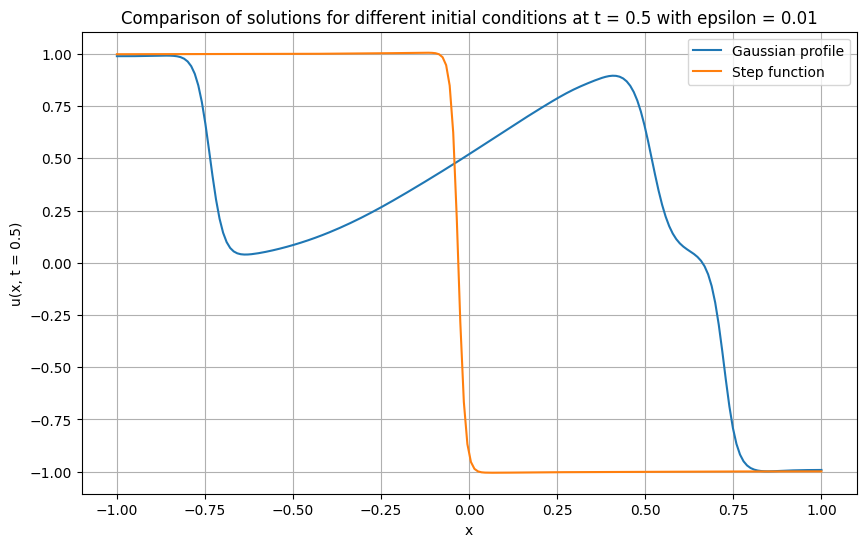

In [ ]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

# Parámetro para la ecuación
epsilon = 0.01  # Viscosidad

# Definir la ecuación de Burgers con viscosidad
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Definir los dominios espaciales y temporales
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Definir las condiciones de frontera
bc_left = dde.DirichletBC(geomtime, lambda x: np.array([1]), on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: np.array([-1]), on_boundary=lambda x, _: np.isclose(x[0], 1))

# Definir la condición inicial: perfil gaussiano
def gaussian_ic(x):
    return np.exp(-10 * (x[:, 0:1])**2)  # Condición inicial gaussiana

# Definir la condición inicial: función de paso
def step_function_ic(x):
    return np.where(x[:, 0:1] < 0, 1.0, -1.0)  # Condición inicial de paso

# Crear una lista de condiciones iniciales (gaussiana y función de paso)
initial_conditions = [gaussian_ic, step_function_ic]
initial_labels = ["Gaussian profile", "Step function"]
solutions = []

# Realizar simulaciones para ambas condiciones iniciales
for ic_func in initial_conditions:
    # Definir la condición inicial para el caso actual
    ic = dde.IC(geomtime, ic_func, lambda _, on_initial: on_initial)

    # Definir el problema
    data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=400, num_boundary=40, num_initial=40)

    # Definir la red neuronal
    net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

    # Definir el modelo
    model = dde.Model(data, net)

    # Entrenar el modelo
    model.compile("adam", lr=0.001)
    model.train(epochs=5000)

    # Generar puntos para predecir en t = 0.5
    x_vals = np.linspace(-1, 1, 200).reshape(-1, 1)
    t_vals = 0.5 * np.ones_like(x_vals)
    X_test = np.hstack((x_vals, t_vals))
    u_pred = model.predict(X_test)

    solutions.append(u_pred)

# Graficar las soluciones para las dos condiciones iniciales
plt.figure(figsize=(10, 6))
for i, label in enumerate(initial_labels):
    plt.plot(x_vals, solutions[i], label=label)
plt.xlabel("x")
plt.ylabel("u(x, t = 0.5)")
plt.legend()
plt.title("Comparison of solutions for different initial conditions at t = 0.5 with epsilon = 0.01")
plt.grid(True)
plt.show()


In [ ]:
from IPython.display import display, Markdown

mermaid_code = """
```mermaid
graph TD
    A[Iniciar el proceso] --> B[Entrenar con Diferencias Finitas]
    A --> C[Entrenar con PINNs]
    A --> D[Entrenar con BLT + PINNs]
    B --> E[Calcular Error L2 y Tiempo - Diferencias Finitas]
    C --> F[Calcular Error L2 y Tiempo - PINNs]
    D --> G[Calcular Error L2 y Tiempo - BLT + PINNs]
    E --> H[Comparar soluciones y errores]
    F --> H[Comparar soluciones y errores]
    G --> H[Comparar soluciones y errores]
    H --> I[Mostrar gráfica comparativa]
    H --> J[Mostrar tabla de errores y tiempos]
"""

display(Markdown(mermaid_code))




```mermaid
graph TD
    A[Iniciar el proceso] --> B[Entrenar con Diferencias Finitas]
    A --> C[Entrenar con PINNs]
    A --> D[Entrenar con BLT + PINNs]
    B --> E[Calcular Error L2 y Tiempo - Diferencias Finitas]
    C --> F[Calcular Error L2 y Tiempo - PINNs]
    D --> G[Calcular Error L2 y Tiempo - BLT + PINNs]
    E --> H[Comparar soluciones y errores]
    F --> H[Comparar soluciones y errores]
    G --> H[Comparar soluciones y errores]
    H --> I[Mostrar gráfica comparativa]
    H --> J[Mostrar tabla de errores y tiempos]


In [ ]:
import base64
from IPython.display import Image, display

def mm(graph):
    graphbytes = graph.encode("utf8")
    base64_bytes = base64.urlsafe_b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    display(Image(url="https://mermaid.ink/img/" + base64_string))

mm("""
graph TD
    A[Start process] --> B[Train with Finite Differences]
    A --> C[Train with PINNs]
    A --> D[Train with BLT + PINNs]
    B --> E[Calculate L2 Error and Time - Finite Differences]
    C --> F[Calculate L2 Error and Time - PINNs]
    D --> G[Calculate L2 Error and Time - BLT + PINNs]
    E --> H[Compare solutions and errors]
    F --> H[Compare solutions and errors]
    G --> H[Compare solutions and errors]
    H --> I[Show comparative graph]
    H --> J[Show error and time table]
""")


In [ ]:
import base64
from IPython.display import Image, display

def mm(graph):
    graphbytes = graph.encode("utf8")
    base64_bytes = base64.urlsafe_b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    display(Image(url="https://mermaid.ink/img/" + base64_string))




mm("""
graph TD
    A[Start process] --> B[Apply Boundary Layer Theory for Initial Conditions]
    A --> C[Define PINNs Model]
    B --> D[Set Initial and Boundary Conditions with BLT]
    C --> E[Train with Adam Optimizer]
    E --> F[Fine-tune with L-BFGS Optimizer]
    F --> G[Make Predictions]
    G --> H[Compare Predictions with Exact Solution]
    H --> I[Calculate L2 Error and Training Time]
    I --> J[Show Comparative Graph]
    I --> K[Show Error and Time Table]
""")


In [ ]:
import base64
from IPython.display import Image, display

def mm(graph):
    graphbytes = graph.encode("utf8")
    base64_bytes = base64.urlsafe_b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    display(Image(url="https://mermaid.ink/img/" + base64_string))

mm("""
graph TD
    A[Start Process] --> B[Apply BLT for Initial Conditions]
    A --> C[Define PINNs Model]
    B --> D[Set Initial and Boundary Conditions with BLT]
    D --> E[Combine BLT and PINNs]
    C --> E
    E --> F[Train with Adam Optimizer]
    F --> G[Fine-tune with L-BFGS Optimizer]
    G --> H[Make Predictions]
    H --> I[Compare Predictions with Exact Solution]
    I --> J[Calculate L2 Error and Training Time]
    J --> K[Show Comparative Graph]
    J --> L[Show Error and Time Table]
""")


In [ ]:
import base64
from IPython.display import Image, display

def mm(graph):
    graphbytes = graph.encode("utf8")
    base64_bytes = base64.urlsafe_b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    display(Image(url="https://mermaid.ink/img/" + base64_string))

mm("""
graph TD
    A[Start Process] --> B[Apply BLT for Initial Conditions]
    B --> C[Define PINNs Model]
    C --> D[Set Initial and Boundary Conditions with BLT]
    D --> E[Train PINNs with Adam]
    E --> F[Fine-tune PINNs with L-BFGS]
    F --> G[Make Predictions]
    G --> H[Compare Predictions with Exact Solution]
    H --> I[Calculate L2 Error]
    I --> J[Show Comparative Graph]
    I --> K[Show Error and Time Table]
""")
